<a href="https://colab.research.google.com/github/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/StockPrediction_withNLP/GameStop(GME)Forecasting_LSTM_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip yfinance -q
!pip install torchmetrics -q
!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 11.9 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import seaborn as sns
import random
import numpy as np
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummaryX import summary
from tqdm.auto import tqdm
import os
import gc
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torchmetrics.regression import MeanAbsolutePercentageError

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


cuda:0


In [ ]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from scipy.stats import spearmanr as spearman
def get_metrics(prediction, true_labels):
  metrics = ['MSE', 'RMSE','MAE', 'MAPE', 'Serial Corr', 'Pearson Corr(IC),', 'Spearman Corr(IC)']
  metrics_value = [
  MSE(prediction,true_labels),
  MSE(prediction,true_labels)**0.5,
  MAE(prediction,true_labels),
  MAPE(prediction,true_labels),
  np.corrcoef(prediction,true_labels)[0,1],
  np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1],
  spearman(np.diff(prediction),np.diff(true_labels))[0],
  ]

  return pd.DataFrame([metrics_value], columns=metrics)


# **Scrape all S&P500 stocks with yahoo finance**

In [227]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url)
sp500_tickers = table[0]['Symbol'].tolist()
sp500_tickers.append('GME') #include GME, GME is kicked out of sp500???
pd.DataFrame(sp500_tickers)

In [226]:
stock_start_date = datetime.date(2018,1,1)
stock_end_date = datetime.date.today()
unfound_list =['BRK.B','BF.B'] #those bankrupted!!!
sp500_tickers = [i for i in sp500_tickers if i not in unfound_list]
for i, ticker in tqdm(enumerate(sp500_tickers), "scraping..."):
  yf.pdr_override()
  stock_ticker = ticker
  if i==0:
    stock_df = pdr.get_data_yahoo(stock_ticker, start=stock_start_date, end=stock_end_date)
  else:
    new_stock = pdr.get_data_yahoo(stock_ticker, start=stock_start_date, end=stock_end_date)
    if len(new_stock)>=len(stock_df)/2:
      stock_df = pd.concat([stock_df, new_stock], axis = 1)
    else:
      unfound_list.append(ticker)

sp500_tickers = [i for i in sp500_tickers if i not in unfound_list]
multi_index=pd.MultiIndex.from_product([sp500_tickers, ['Open','High','Low','Close','Adj Close','Volume']], names=['Ticker', 'Attribute'])
stock_df.columns = multi_index
stock_df

In [228]:
print(stock_df.isnull().sum().max())
stock_df = stock_df.fillna( method='bfill')
print(stock_df.isnull().sum().max())
stock_df.to_csv("s&p500_stocks.csv")

# **Load Reddit News & Create Dataset of Time Series News Combined**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]
# df_reddit = df_reddit[df_reddit['title'].apply(lambda x: len(x.split()) > 3 and len(x.split())<1000)]
df_reddit


<ipython-input-4-ede0d2593afc>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]


date                                              title  score  \
0        2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀    1.0   
1        2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀    1.0   
2        2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...    1.0   
3        2021-01-05  You already know what we must do brothers and ...    1.0   
4        2021-01-06                          ICR conference (11th Jan)    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  Hedgies are relics of past generations- they h...    1.0   
1033232  2021-12-31                                    Snapchat on 🔥🔥🔥    1.0   
1033233  2021-12-31  MOASS has ruined me this year. But I will stil...    1.0   
1033234  2021-12-31                               Patterns for 2022???    1.0   
1033235  2021-12-31                                        When GWagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

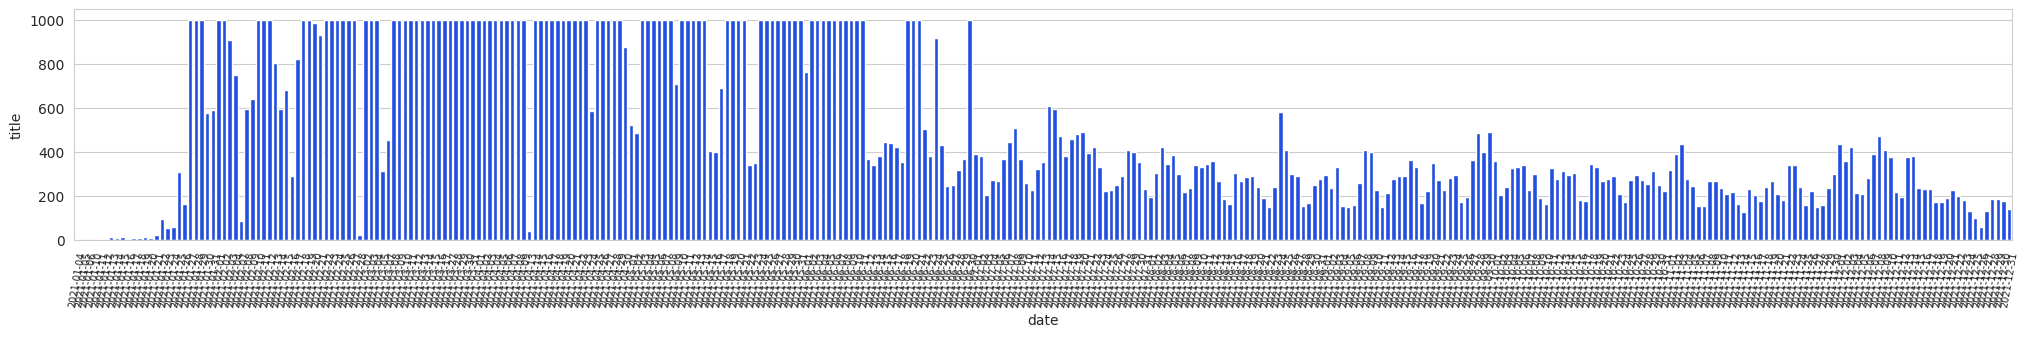

In [5]:
plt.figure(figsize=(25,3))
sns.set_style("whitegrid")
sns.set_palette("bright")
df_count = df_reddit.groupby('date').count().reset_index()
df_count['title']=df_count['title'].clip(0,1000)
sns.barplot(df_count, x='date', y='title')
plt.xticks(rotation=80, fontsize=7)
plt.show()

In [6]:
!pip install emoji -q
import emoji

def clean_text(text):
    import re
    text = emoji.demojize(text, delimiters=(" ", " "))  #emojis are important, keep them
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text
df_reddit['title'] = df_reddit['title'].map(clean_text)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.4 MB/s eta 0:00:00


### **EDA on January titles to study the event**

In [20]:
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/s&p500_stocks.csv', index_col=[0], header=[0,1]).drop('Adj Close', level='Attribute', axis=1)
df.index = pd.to_datetime(df.index)
df = df.loc[:,('GME')].reset_index()
df

Attribute       Date     Open     High     Low    Close    Volume
0         2018-01-02   4.4900   4.5725   4.445   4.5650  11330800
1         2018-01-03   4.5725   4.5925   4.480   4.5500  15156800
2         2018-01-04   4.5500   4.5950   4.490   4.5800  11125200
3         2018-01-05   4.5950   4.6825   4.555   4.6700  12076000
4         2018-01-08   4.7000   4.8500   4.700   4.8075  14673600
...              ...      ...      ...     ...      ...       ...
1523      2024-01-23  15.0000  15.0200  14.050  14.1800   3495300
1524      2024-01-24  14.2800  14.3800  13.820  13.9500   2513800
1525      2024-01-25  13.9700  14.5400  13.920  14.5200   3635900
1526      2024-01-26  14.4400  14.7200  14.410  14.4900   2282300
1527      2024-01-29  14.5000  14.8100  14.320  14.7800   2164200

[1528 rows x 6 columns]

In [198]:
df_event = df_reddit[pd.to_datetime(df_reddit['date'])<=pd.to_datetime('2021-03-01')]
df_event['date'] = pd.to_datetime(df_event['date'])
df_event_price = df[(pd.to_datetime(df['Date'])<=pd.to_datetime('2021-03-01')) & (pd.to_datetime(df['Date'])>=pd.to_datetime('2021-01-04'))].reset_index(drop=True)
df_event_price['Date'] = pd.to_datetime(df_event_price['Date'])
df_event = df_event[df_event['date'].isin(df_event_price['Date'])]
df_event_price = df_event_price[df_event_price['Date'].isin(df_event['date'])]
df_event.date.unique().shape, df_event_price.Date.unique().shape
df_event_price = df_event_price.reset_index()
df_event = df_event.reset_index()

<ipython-input-198-298da8059486>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event['date'] = pd.to_datetime(df_event['date'])


((35,), (35,))

**User Finbert to study the event first**

In [122]:
from transformers import BertTokenizer, BertForSequenceClassification
finbert_name = "yiyanghkust/finbert-tone"
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_name)
finbert = BertForSequenceClassification.from_pretrained(finbert_name).to(device)

In [187]:
df_event_sample = df_event[['date', 'title']].groupby('date').apply(lambda x: x.sample(min(len(x), 500))).reset_index(drop=True)
df_event_sample

date                                              title
0     2021-01-04  short squeeze incoming  rocket  rocket  rocket...
1     2021-01-04  you need to see this about gme  rocket  rocket...
2     2021-01-05  this convinced me to all in  money_bag gme ext...
3     2021-01-05  you already know what we must do brothers and ...
4     2021-01-06  hey guys we have a free discord channel thats ...
...          ...                                                ...
10953 2021-02-26                                              40001
10954 2021-02-26                     lets call todays dip the diplo
10955 2021-02-26  no need to resist this fellow apes youre weak ...
10956 2021-02-26              ing diba are you serious why no xetra
10957 2021-02-26  remember the video of ws drinking champagne an...

[10958 rows x 2 columns]

In [188]:
def finbert_tokenize(x,max_length=50):
  out = finbert_tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=max_length,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )
  return out
df_event_tokenized = df_event_sample['title'].apply(lambda x: finbert_tokenize(x))
df_vec_event = df_event_tokenized.values
print("Shape of tokenized vector:",df_vec_event.shape)
print("shape of one news:", df_vec_event[0]['input_ids'].shape)
df_vec_event[0]

Shape of tokenized vector: (10958,)
shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[    3,  1072, 15212, 19553, 22878, 22878, 22878, 22878, 22878, 22878,
         22878,     4,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [189]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index].to(device), self.token_type_ids[index].to(device), self.att_mask[index].to(device))
inference_data = NLPDataset(df_vec_event)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 328,
    shuffle=False
)
len(inference_data)

10958

In [190]:
# del X
gc.collect()
torch.cuda.empty_cache()

In [191]:
sentiments = []
for X in tqdm(inference_loader, "inferencing..."):
  input_ids, token_type_ids, attention_mask = X
  res = finbert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask= attention_mask)
  # print(res)
  res = res.logits.cpu().detach().numpy()
  sentiments.append(res)
  del X
  gc.collect()
  torch.cuda.empty_cache()

df_sentiment = df_event_sample.copy()
df_sentiment['sentiment'] = np.vstack(sentiments).argmax(1)
df_sentiment

inferencing...:   0%|          | 0/34 [00:00<?, ?it/s]

date                                              title  sentiment
0     2021-01-04  short squeeze incoming  rocket  rocket  rocket...          0
1     2021-01-04  you need to see this about gme  rocket  rocket...          0
2     2021-01-05  this convinced me to all in  money_bag gme ext...          0
3     2021-01-05  you already know what we must do brothers and ...          0
4     2021-01-06  hey guys we have a free discord channel thats ...          0
...          ...                                                ...        ...
10953 2021-02-26                                              40001          0
10954 2021-02-26                     lets call todays dip the diplo          0
10955 2021-02-26  no need to resist this fellow apes youre weak ...          0
10956 2021-02-26              ing diba are you serious why no xetra          0
10957 2021-02-26  remember the video of ws drinking champagne an...          0

[10958 rows x 3 columns]

In [192]:
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(lambda x: -1 if x==2 else x)
np.unique(df_sentiment['sentiment'].values, return_counts=True)

(array([-1,  0,  1]), array([ 890, 9112,  956]))

<ipython-input-215-7acede1cd71c>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80, fontsize=7)


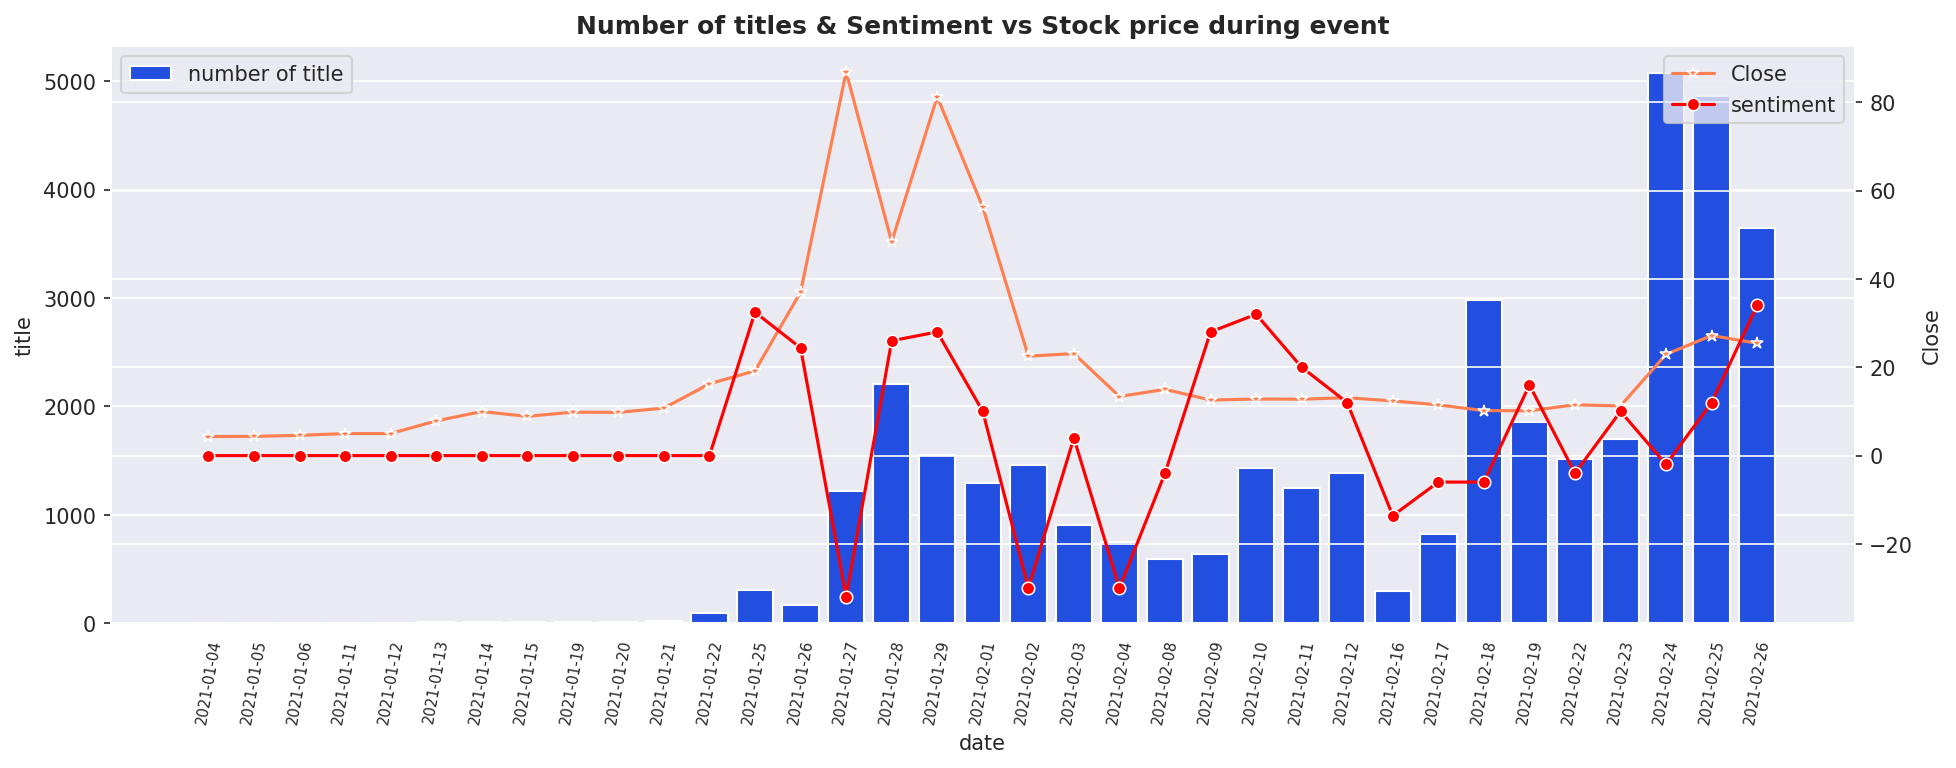

In [215]:
plt.figure(figsize=(15, 5),dpi=150)
sns.set_style("darkgrid")
sns.set_palette("bright")

condition = df_sentiment.groupby('date')['sentiment'].count()<50
df_sent = df_sentiment.groupby('date', as_index=False)['sentiment'].mean()
df_sent.loc[condition.values, 'sentiment']*=0
df_count = df_event.groupby('date', as_index=False)['title'].count()
ax1 = sns.barplot(data=df_count, x='date', y='title', label = 'number of title')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80, fontsize=7)

ax2 = ax1.twinx()
sns.lineplot(df_event_price['Close'], ax=ax2, color='coral', label = 'Close', marker='*')
sns.lineplot(df_sent['sentiment']*1000, ax=ax2, color='red', label='sentiment', marker='o')
plt.title('Number of titles & Sentiment vs Stock price during event', fontweight='bold')
plt.legend()
plt.show()

In [225]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(df_sentiment[df_sentiment['date']=='2021-01-27'])

date                                              title  sentiment
664  2021-01-27  my account got suspended hl london order suspe...         -1
665  2021-01-27                      rocket  taken down discussion          0
666  2021-01-27  every one are u thinking we going to land on m...          0
667  2021-01-27  no one answered the question will gme issue sh...          0
668  2021-01-27  keep holding on and buying until we reach 1000...          0
...         ...                                                ...        ...
1159 2021-01-27  sell guys rn get it down to 200s then everyone...          0
1160 2021-01-27  at least all of the users on trading 212 will ...          0
1161 2021-01-27                                        sooooon gme          0
1162 2021-01-27                          hold da line payday comin          0
1163 2021-01-27  rwallstreetsbets are just waiting for reddit a...          0

[500 rows x 3 columns]

In [224]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  display(df_sentiment[df_sentiment['date']=='2021-02-02'])

date                                              title  sentiment
2664 2021-02-02  until they start to bleed  raised_fist_mediuml...          0
2665 2021-02-02  just bought 3 more in the dip not much but wha...          0
2666 2021-02-02  nyse to put gme on the short sale restriction ...          0
2667 2021-02-02  remember all the fomo from last week people bi...         -1
2668 2021-02-02                        are people able to buy yet           0
2669 2021-02-02     robinhood news is the worst shit ive ever seen         -1
2670 2021-02-02                                             hghghg          0
2671 2021-02-02                      gme silver membership renewed          0
2672 2021-02-02  gme until i die but pay attention to a long te...          1
2673 2021-02-02  gme to the moon lambo soon hold the fckn games...          0
2674 2021-02-02                     brother s and sister swamp won          0
2675 2021-02-02                                         feels good          1
2676 2021-02-02  hottest stock marketing strategy you could eve...          0
2677 2021-02-02              keep buying the dip this is temporary         -1
2678 2021-02-02  how many people are taking part in gme from th...          0
2679 2021-02-02  we can longer stay irrational then they can st...          0
2680 2021-02-02                               another red day tmrw          0
2681 2021-02-02                                 outstanding shorts          0
2682 2021-02-02                           will it rise back up omg          0
2683 2021-02-02                                                wth          0
2684 2021-02-02  gme aquarius stellium and february transits lo...          0
2685 2021-02-02                   short interest list as of 222021          0
2686 2021-02-02                                     halted at13025         -1
2687 2021-02-02                    did the same thing happen to us          0
2688 2021-02-02                                         ladder ban          0
2689 2021-02-02                                    fromsouth korea          0
2690 2021-02-02  dont waver and hold  rocket  we ought to be pa...          0
2691 2021-02-02                   a dip is coming brace yourselves          0
2692 2021-02-02  the only way we are going to recoup our losses...          0
2693 2021-02-02                   this is what happens with gme rn          0
2694 2021-02-02  lawyer suing robinhood for forced sale  exerci...          0
2695 2021-02-02                      need to be realistic its over         -1
2696 2021-02-02  just did my second buy today i am counting on ...          0
2697 2021-02-02               gme trading just suspended in webull          0
2698 2021-02-02  ignore the bots telling you to sell  telling y...          1
2699 2021-02-02                              fidelity account down         -1
2700 2021-02-02                           gme you need to buy more          0
2701 2021-02-02   globe_showing_americas    first_quarter_moon ...         -1
2702 2021-02-02                                   so that happened         -1
2703 2021-02-02         everyone buy whilst its cheap eyes  dizzy           0
2704 2021-02-02                                       lets be real          0
2705 2021-02-02                   thoughts on todays closing price          0
2706 2021-02-02                                open shares covered          0
2707 2021-02-02                                      weak drop  46         -1
2708 2021-02-02          robinhood is limiting shares get this now          0
2709 2021-02-02                                               read          0
2710 2021-02-02                          gme frozen at 11951 on rh          0
2711 2021-02-02  bouvet a total of 25 for a breakeven at 239 ho...          0
2712 2021-02-02  the size of this is insane ive never been so p...         -1
2713 2021-02-02  this is probably as accurate as you can expect...          0
2714 2021-02-02           holding

## **Each day sample 300 news**

In [ ]:
df_news = df_reddit.groupby('date').apply(lambda x: x.sample(min(len(x), 300))).reset_index(drop=True)
df_news

date                                              title  score  \
0       2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
1       2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
2       2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3       2021-01-05  you already know what we must do brothers and ...    1.0   
4       2021-01-06  hey guys we have a free discord channel thats ...    1.0   
...            ...                                                ...    ...   
170322  2021-12-31                                      2021 timeline    1.0   
170323  2021-12-31                                happy new year apes    1.0   
170324  2021-12-31  hold gme moon was testing out my word per minu...    1.0   
170325  2021-12-31  i got my cs letter today time for account veri...    1.0   
170326  2021-12-31  short interest has fallen 5  doesnt matter 165...    1.0   

        num_comments  
0                9.0  
1                1.0  
2                6.0  
3                4.0  
4               15.0  
...              ...  
170322           0.0  
170323           0.0  
170324           0.0  
170325           0.0  
170326           0.0  

[170327 rows x 4 columns]

## **Load Time Series and Combine with News**

In [19]:
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/s&p500_stocks.csv', index_col=[0], header=[0,1]).drop('Adj Close', level='Attribute', axis=1)
df.index = pd.to_datetime(df.index)
df = df.loc[:,('GME')].reset_index()
df

Attribute       Date     Open     High     Low    Close    Volume
0         2018-01-02   4.4900   4.5725   4.445   4.5650  11330800
1         2018-01-03   4.5725   4.5925   4.480   4.5500  15156800
2         2018-01-04   4.5500   4.5950   4.490   4.5800  11125200
3         2018-01-05   4.5950   4.6825   4.555   4.6700  12076000
4         2018-01-08   4.7000   4.8500   4.700   4.8075  14673600
...              ...      ...      ...     ...      ...       ...
1523      2024-01-23  15.0000  15.0200  14.050  14.1800   3495300
1524      2024-01-24  14.2800  14.3800  13.820  13.9500   2513800
1525      2024-01-25  13.9700  14.5400  13.920  14.5200   3635900
1526      2024-01-26  14.4400  14.7200  14.410  14.4900   2282300
1527      2024-01-29  14.5000  14.8100  14.320  14.7800   2164200

[1528 rows x 6 columns]

In [ ]:
df_news['date'] = pd.to_datetime(df_news['date'])
df_gme_full=df_news.merge(df, how ='inner', left_on = 'date', right_on='Date').drop(columns=['date'])
df_gme_full

title  score  \
0       you need to see this about gme  rocket  rocket...    1.0   
1       short squeeze incoming  rocket  rocket  rocket...    1.0   
2       this convinced me to all in  money_bag gme ext...    1.0   
3       you already know what we must do brothers and ...    1.0   
4       hey guys we have a free discord channel thats ...    1.0   
...                                                   ...    ...   
129394                                      2021 timeline    1.0   
129395                                happy new year apes    1.0   
129396  hold gme moon was testing out my word per minu...    1.0   
129397  i got my cs letter today time for account veri...    1.0   
129398  short interest has fallen 5  doesnt matter 165...    1.0   

        num_comments       Date       Open       High        Low    Close  \
0                9.0 2021-01-04   4.750000   4.775000   4.287500   4.3125   
1                1.0 2021-01-04   4.750000   4.775000   4.287500   4.3125   
2                6.0 2021-01-05   4.337500   4.520000   4.307500   4.3425   
3                4.0 2021-01-05   4.337500   4.520000   4.307500   4.3425   
4               15.0 2021-01-06   4.335000   4.745000   4.332500   4.5900   
...              ...        ...        ...        ...        ...      ...   
129394           0.0 2021-12-31  38.404999  39.182499  37.025002  37.0975   
129395           0.0 2021-12-31  38.404999  39.182499  37.025002  37.0975   
129396           0.0 2021-12-31  38.404999  39.182499  37.025002  37.0975   
129397           0.0 2021-12-31  38.404999  39.182499  37.025002  37.0975   
129398           0.0 2021-12-31  38.404999  39.182499  37.025002  37.0975   

          Volume  
0       40090000  
1       40090000  
2       19846000  
3       19846000  
4       24224800  
...          ...  
129394   5576000  
129395   5576000  
129396   5576000  
129397   5576000  
129398   5576000  

[129399 rows x 9 columns]

## **How many News each day vs Stock Price**

<ipython-input-153-455dc35b16d1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)


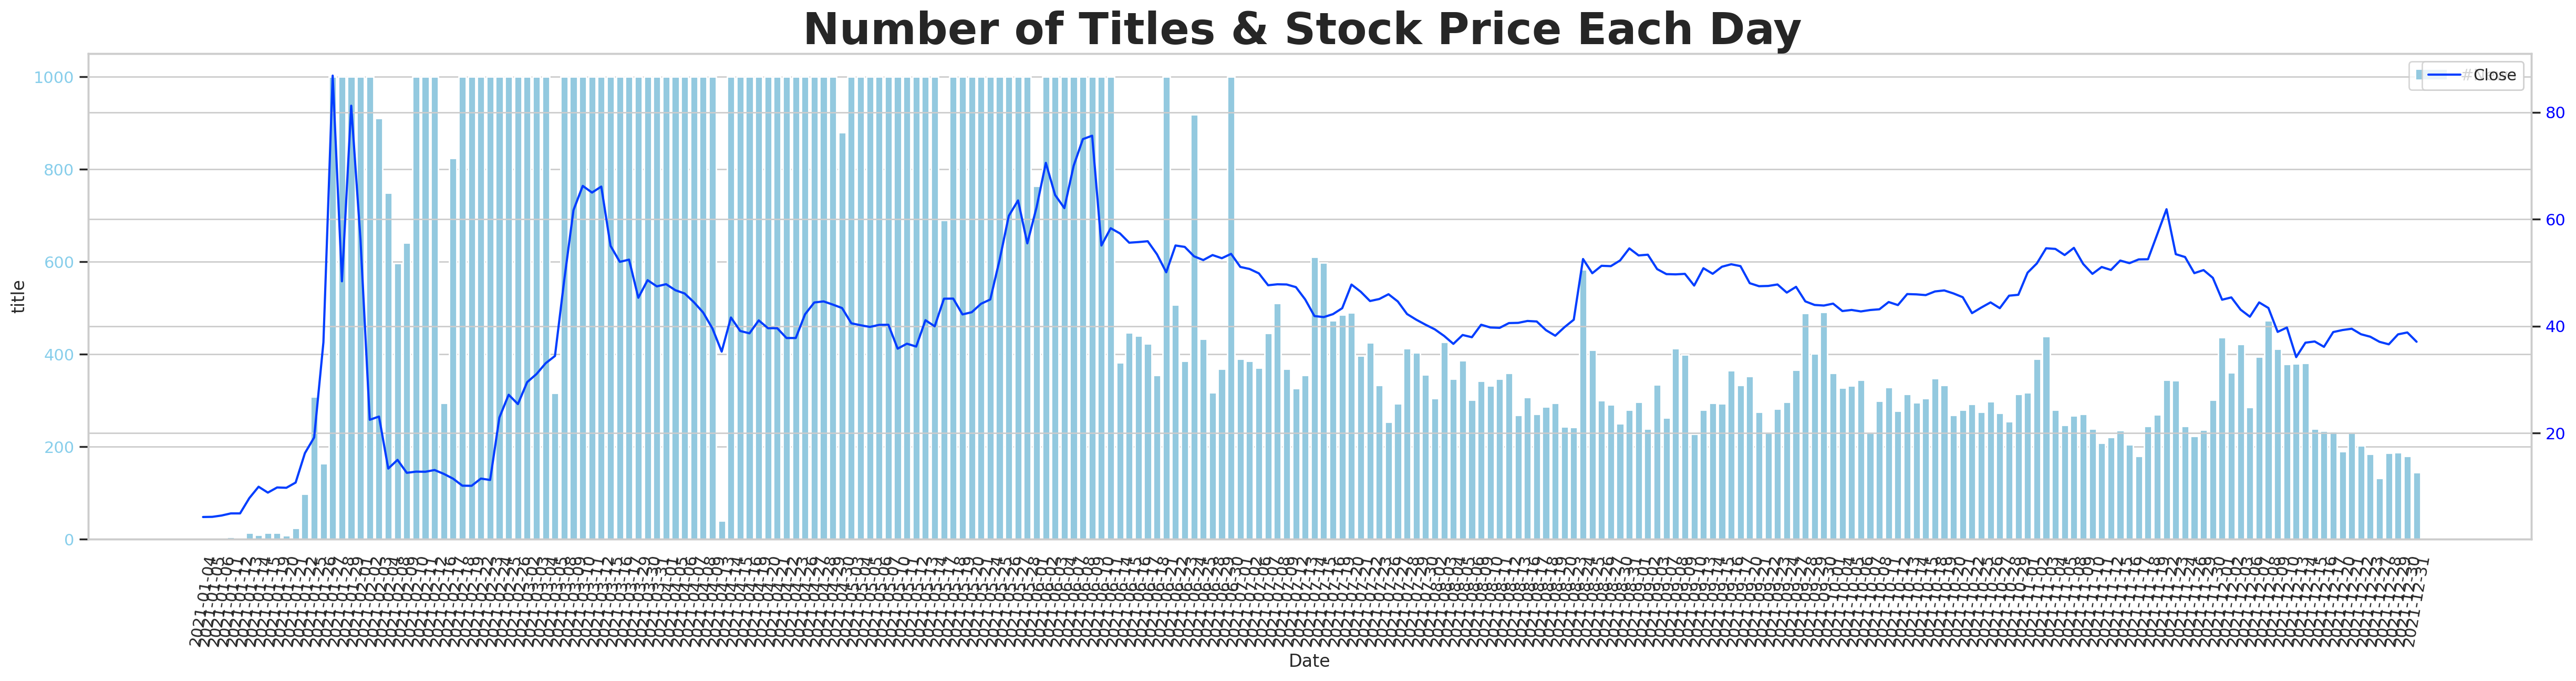

In [ ]:
fig, ax1 = plt.subplots(figsize=(30, 6), dpi=200)
color = 'skyblue'
num_titles = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','title']].groupby('Date').count().reset_index()
# num_titles['Date'] = num_titles['Date'].apply(lambda x: str(x))
sns.barplot(num_titles, x='Date', y='title',color=color, ax=ax1, label="#News")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)

ax2 = ax1.twinx()
color = 'blue'
price = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','Close']].groupby('Date').mean().reset_index()
# price['Date'] = price['Date'].apply(lambda x: str(x))
sns.lineplot(price, color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Number of Titles & Stock Price Each Day ", fontweight='bold', fontsize=30)
plt.show()

In [ ]:
df_gme_full.to_csv("2021_ts_news.csv")

# **Load Time Series & News Combined**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = df_gme_full
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/2021_ts_news.csv').drop(columns=['Unnamed: 0']).dropna()
df

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

             Date       Open       High        Low    Close    Volume  
0      2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
1      2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
2      2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
3      2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
4      2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800  
...           ...        ...        ...        ...      ...       ...  
65056  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65057  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65058  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65059  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65060  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  

[65033 rows x 9 columns]

# **Explore Bert Sentiment Analysis**

## **Inference sentiment with Bert fine-tuned**

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

In [ ]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [ ]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index])

In [ ]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 328,
    shuffle=False
)


In [ ]:
# del X
gc.collect()
torch.cuda.empty_cache()

In [ ]:
sentiments = []
for X in tqdm(inference_loader, "inferencing..."):

  res = model(X).cpu().detach().numpy()
  sentiments.append(res)
  del X
  gc.collect()
  torch.cuda.empty_cache()

df_sentiment = df.copy()
df_sentiment['sentiment'] = np.vstack(sentiments).argmax(1)
df_sentiment

inferencing...:   0%|          | 0/199 [00:00<?, ?it/s]

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

             Date       Open       High        Low    Close    Volume  \
0      2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
1      2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
2      2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
3      2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
4      2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800   
...           ...        ...        ...        ...      ...       ...   
65056  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65057  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65058  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65059  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65060  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   

       sentiment  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
65056          0  
65057          0  
65058          0  
65059          0  
65060          0  

[65033 rows x 10 columns]

In [ ]:
df_s = df_sentiment[['sentiment','Close']].groupby('sentiment').count()
# df_s = df_s.rename(columns={'Close':'count'})
df_s

Close
sentiment       
0          49391
1           1479
2          14163

In [ ]:
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(lambda x: -1 if x==2 else x)
df_sentiment

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

             Date       Open       High        Low    Close    Volume  \
0      2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
1      2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
2      2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
3      2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
4      2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800   
...           ...        ...        ...        ...      ...       ...   
65056  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65057  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65058  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65059  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65060  2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   

       sentiment  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
65056          0  
65057          0  
65058          0  
65059          0  
65060          0  

[65033 rows x 10 columns]

In [ ]:
dff = df_sentiment[df_sentiment.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)
dff['sentiment_change'] = dff['sentiment'].diff().fillna(0)
dff

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  sentiment  price_change  sentiment_change  
Date                                                                           
2021-01-04      5.000000  1.000000   0.000000      0.000000          0.000000  
2021-01-05      5.000000  1.000000   0.000000      0.030000          0.000000  
2021-01-06     12.500000  1.000000   0.000000      0.247500          0.000000  
2021-01-11      9.500000  1.250000  -0.250000      0.395000         -0.250000  
2021-01-12     12.000000  1.500000  -0.500000      0.002500         -0.250000  
...                  ...       ...        ...           ...               ...  
2021-12-27      0.007576  1.007576  -0.098485     -0.957500         -0.049572  
2021-12-28      0.010753  1.005376  -0.155914     -0.462498         -0.057429  
2021-12-29      0.010695  1.000000  -0.192513      1.867496         -0.036599  
2021-12-30      0.005556  1.022222  -0.105556      0.350002          0.086958  
2021-12-31      0.013889  1.013889  -0.131944     -1.735001         -0.026389  

[240 rows x 10 columns]

## **Correlation between Sentiment & Price**

<Axes: xlabel='Date', ylabel='price_change'>

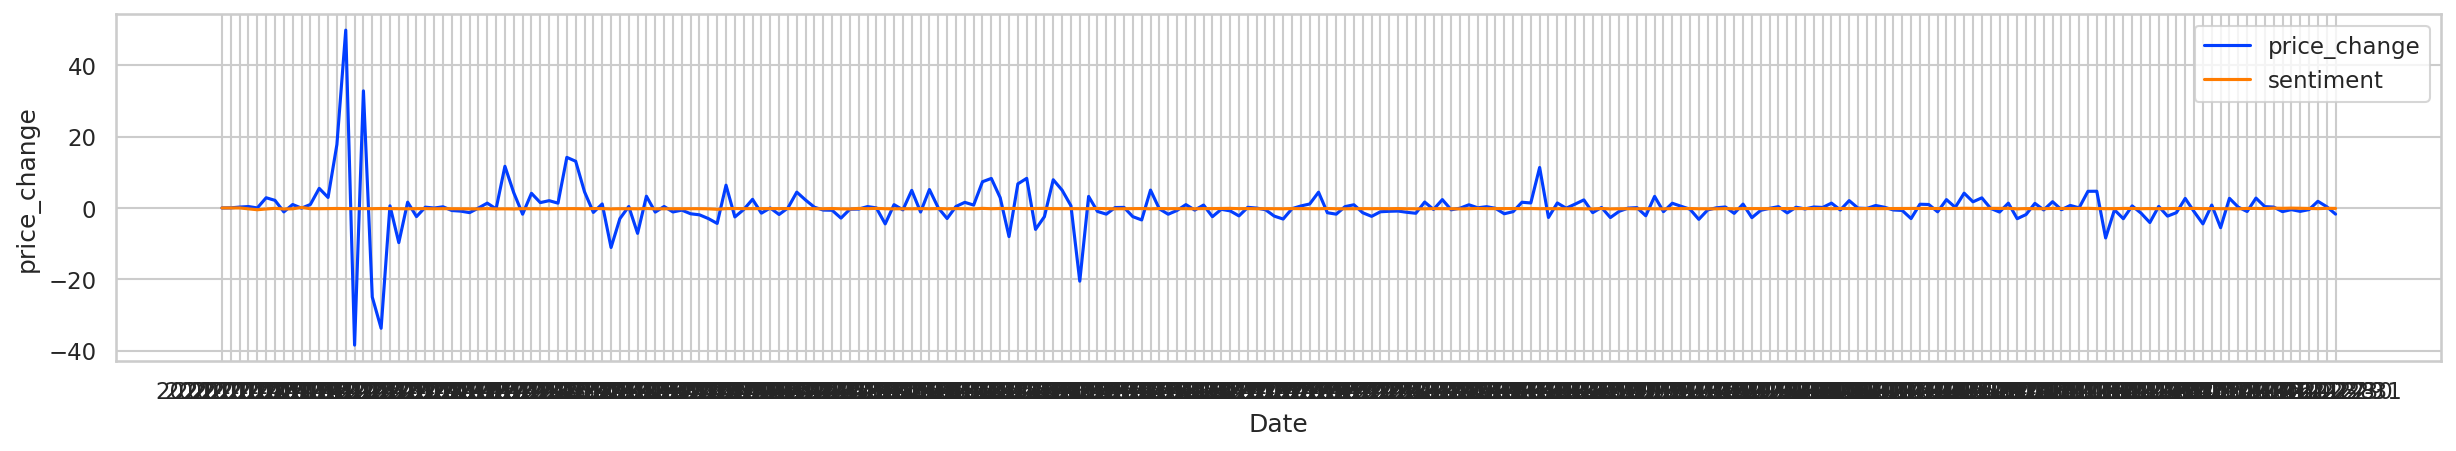

In [ ]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment'], label = 'sentiment')


<Axes: xlabel='Date', ylabel='price_change'>

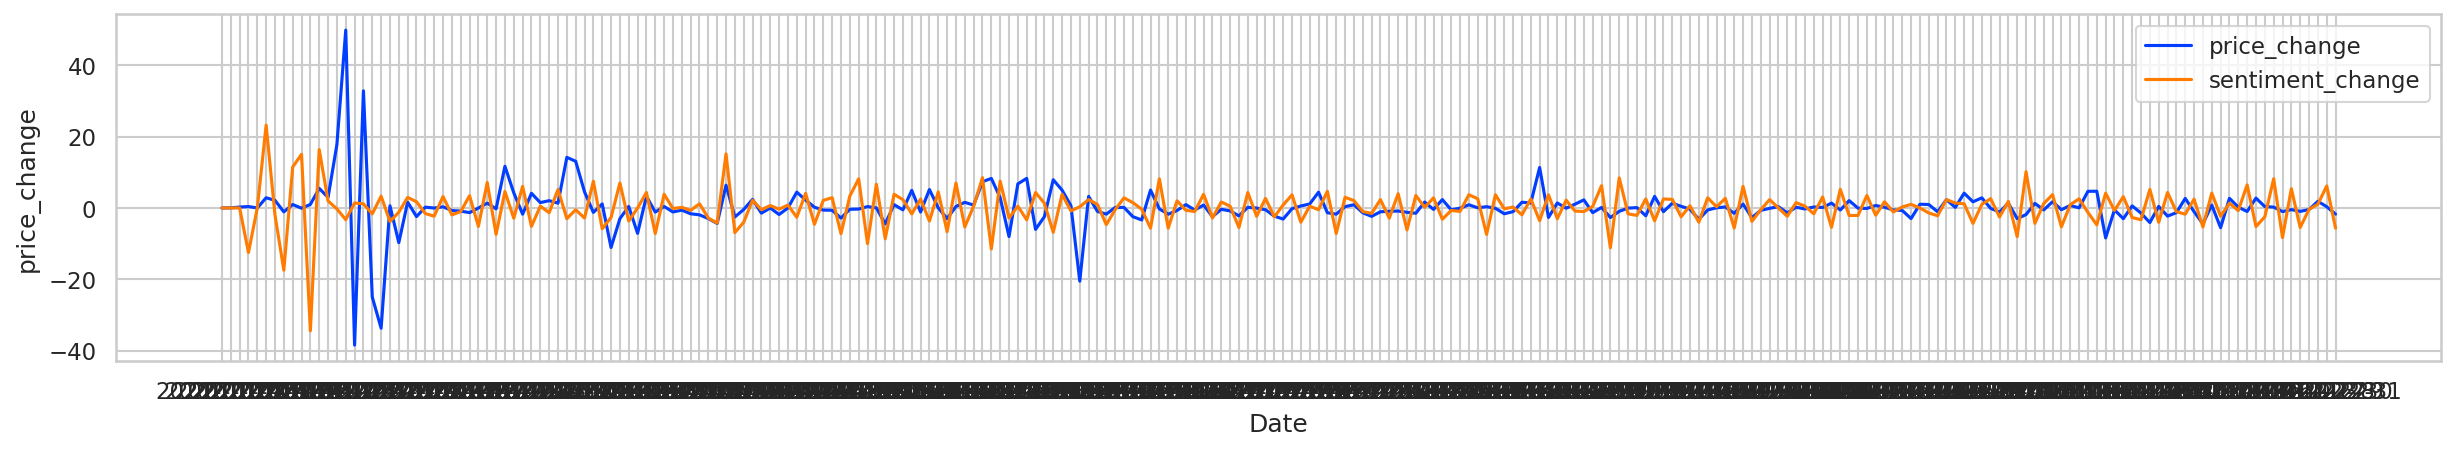

In [ ]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment_change'].diff().fillna(0)*50, label = 'sentiment_change')


<Axes: >

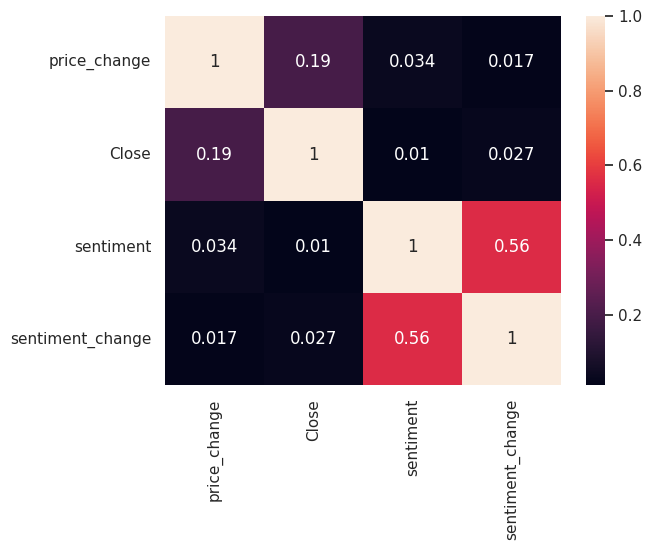

In [ ]:
sns.heatmap(dff[['price_change','Close', 'sentiment','sentiment_change']].corr(),annot=True)

**The sentiment analysis our fine-tuned Bert gives does not give a good correlation with price or price change. Therefore we cannot use it to train LSTM. This can be due to several reasons: \
1.Our Bert is fine tuned on kaggle financial news headlines, which is drastically different from our Reddit post, and the model fails to generalize to Reddit post. \
2.Our model mostly outputs sentiment as neutral, if we could have included only positive and negative classes, or simply using the embeddings, it would give us stronger correlation with the stock price.\
But it serves as a good baseline methods, we'll train LSTM with sentiment labels first, and then explore Tf-idf embeddings, finally explore bert embeddings.**


# **Train with Baseline: with sentiment labels**

In [ ]:
df_ts = dff[['Close', 'High', 'Low', 'Open', 'Volume','sentiment']]
df_ts['Date']= dff.index
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts.drop(columns=['Date'])

<ipython-input-180-0e534ff44ac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date']= dff.index
<ipython-input-180-0e534ff44ac9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date'] = pd.to_datetime(df_ts['Date'])


### **Train Test Split**

In [ ]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [ ]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'sentiment'], dtype='object')


((70, 6), (20, 6), (65, 6))

In [ ]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [ ]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 6])
x:  tensor([-1.4064, -1.3864, -1.3862, -1.2414, -1.1337])
y_train:  tensor([-1.3864, -1.3862, -1.2414, -1.1337, -1.1895])


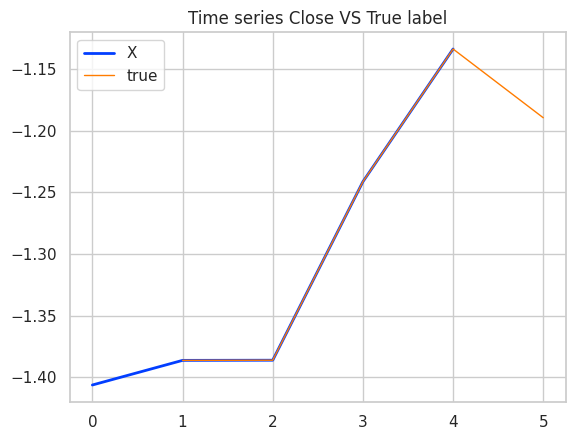

In [ ]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)
sns.set_style("whitegrid")
sns.set_palette("bright")

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [ ]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    self.dp = nn.Dropout(dropout)
  def forward(self, x):
    out,_ = self.lstm(x)
    out = self.dp(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [ ]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-1.0943, -0.8162, -0.6672,  0.2334,  2.7577], device='cuda:0') tensor([-0.8162, -0.6672,  0.2334,  2.7577,  0.8106], device='cuda:0')
x shape: torch.Size([64, 5, 6]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]   1.06496M  1.060864M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [ ]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [ ]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9400	 Learning Rate 0.0020000	 Validation Loss 0.4890

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8606	 Learning Rate 0.0016000	 Validation Loss 0.3491

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7127	 Learning Rate 0.0012800	 Validation Loss 0.1911

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5939	 Learning Rate 0.0010240	 Validation Loss 0.1440

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5765	 Learning Rate 0.0008192	 Validation Loss 0.1672

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5246	 Learning Rate 0.0006554	 Validation Loss 0.1942

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4596	 Learning Rate 0.0005243	 Validation Loss 0.2123

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4191	 Learning Rate 0.0004194	 Validation Loss 0.2211

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4196	 Learning Rate 0.0003355	 Validation Loss 0.2239

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4192	 Learning Rate 0.0002684	 Validation Loss 0.2241

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4026	 Learning Rate 0.0002147	 Validation Loss 0.2227

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3847	 Learning Rate 0.0001718	 Validation Loss 0.2204

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4051	 Learning Rate 0.0001374	 Validation Loss 0.2178

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3734	 Learning Rate 0.0001100	 Validation Loss 0.2149

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3864	 Learning Rate 0.0000880	 Validation Loss 0.2122

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3810	 Learning Rate 0.0000704	 Validation Loss 0.2099

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3794	 Learning Rate 0.0000563	 Validation Loss 0.2078

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3656	 Learning Rate 0.0000450	 Validation Loss 0.2061

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3871	 Learning Rate 0.0000360	 Validation Loss 0.2047

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3675	 Learning Rate 0.0000288	 Validation Loss 0.2036

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3580	 Learning Rate 0.0000231	 Validation Loss 0.2026

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3622	 Learning Rate 0.0000184	 Validation Loss 0.2018

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3609	 Learning Rate 0.0000148	 Validation Loss 0.2011

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3595	 Learning Rate 0.0000118	 Validation Loss 0.2006

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3386	 Learning Rate 0.0000094	 Validation Loss 0.2002

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3817	 Learning Rate 0.0000076	 Validation Loss 0.1998

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3897	 Learning Rate 0.0000060	 Validation Loss 0.1995

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3553	 Learning Rate 0.0000048	 Validation Loss 0.1993

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3670	 Learning Rate 0.0000039	 Validation Loss 0.1991

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3840	 Learning Rate 0.0000031	 Validation Loss 0.1990

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3622	 Learning Rate 0.0000025	 Validation Loss 0.1989

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3383	 Learning Rate 0.0000020	 Validation Loss 0.1988

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3540	 Learning Rate 0.0000016	 Validation Loss 0.1987

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3600	 Learning Rate 0.0000013	 Validation Loss 0.1986

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3702	 Learning Rate 0.0000010	 Validation Loss 0.1986

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3679	 Learning Rate 0.0000008	 Validation Loss 0.1986

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3349	 Learning Rate 0.0000006	 Validation Loss 0.1985

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3754	 Learning Rate 0.0000005	 Validation Loss 0.1985

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3595	 Learning Rate 0.0000004	 Validation Loss 0.1985

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3528	 Learning Rate 0.0000003	 Validation Loss 0.1985

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3608	 Learning Rate 0.0000003	 Validation Loss 0.1984

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3553	 Learning Rate 0.0000002	 Validation Loss 0.1984

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3465	 Learning Rate 0.0000002	 Validation Loss 0.1984

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3658	 Learning Rate 0.0000001	 Validation Loss 0.1984

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3602	 Learning Rate 0.0000001	 Validation Loss 0.1984

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3661	 Learning Rate 0.0000001	 Validation Loss 0.1984

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3622	 Learning Rate 0.0000001	 Validation Loss 0.1984

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3579	 Learning Rate 0.0000001	 Validation Loss 0.1984

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3659	 Learning Rate 0.0000000	 Validation Loss 0.1984

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3513	 Learning Rate 0.0000000	 Validation Loss 0.1984


Text(0.5, 1.0, 'Validation loss')

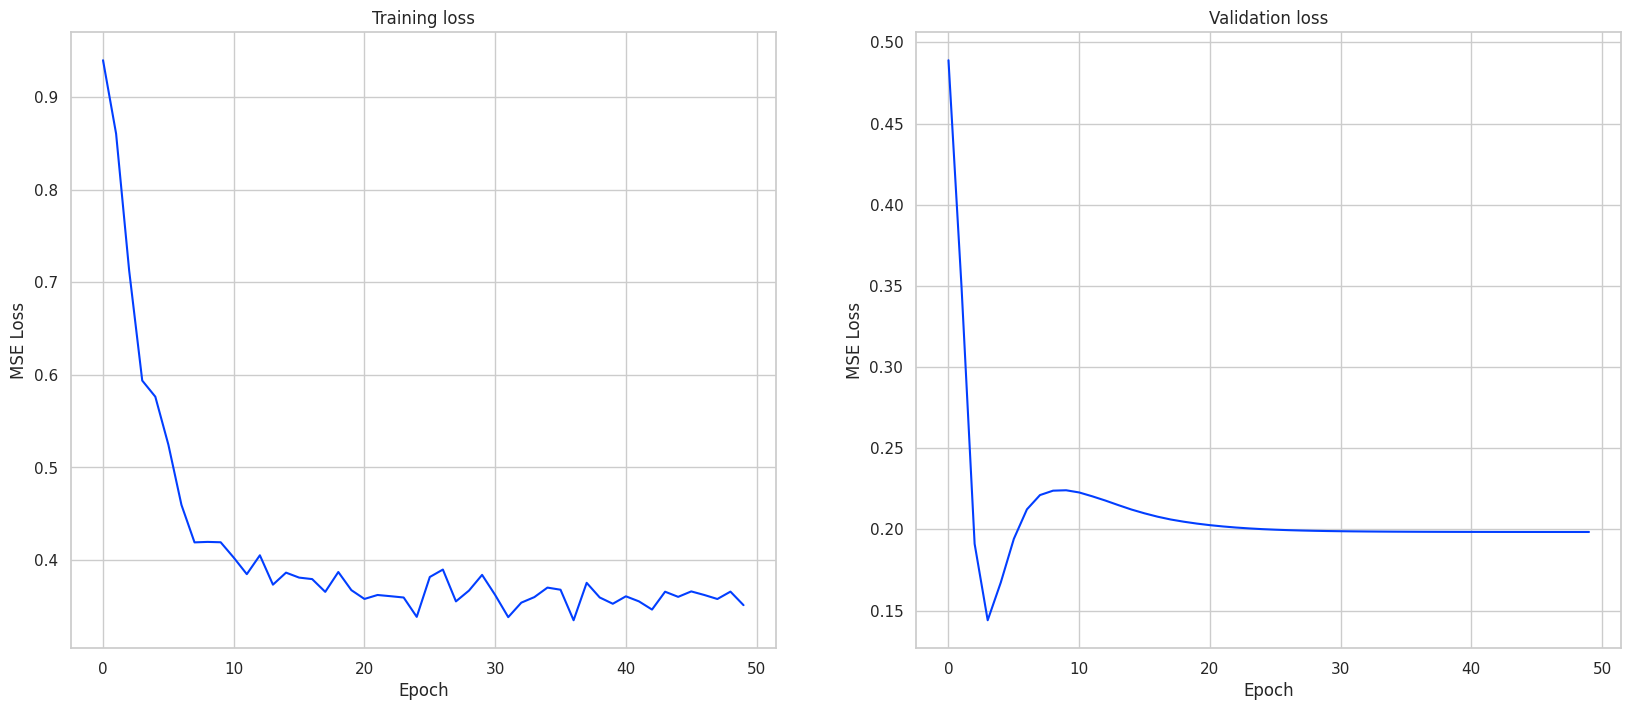

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [ ]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
baseline_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  73.073166  8.548284  6.207523  0.143593     0.873002          -0.177247   

   Spearman Corr(IC)  
0          -0.097482

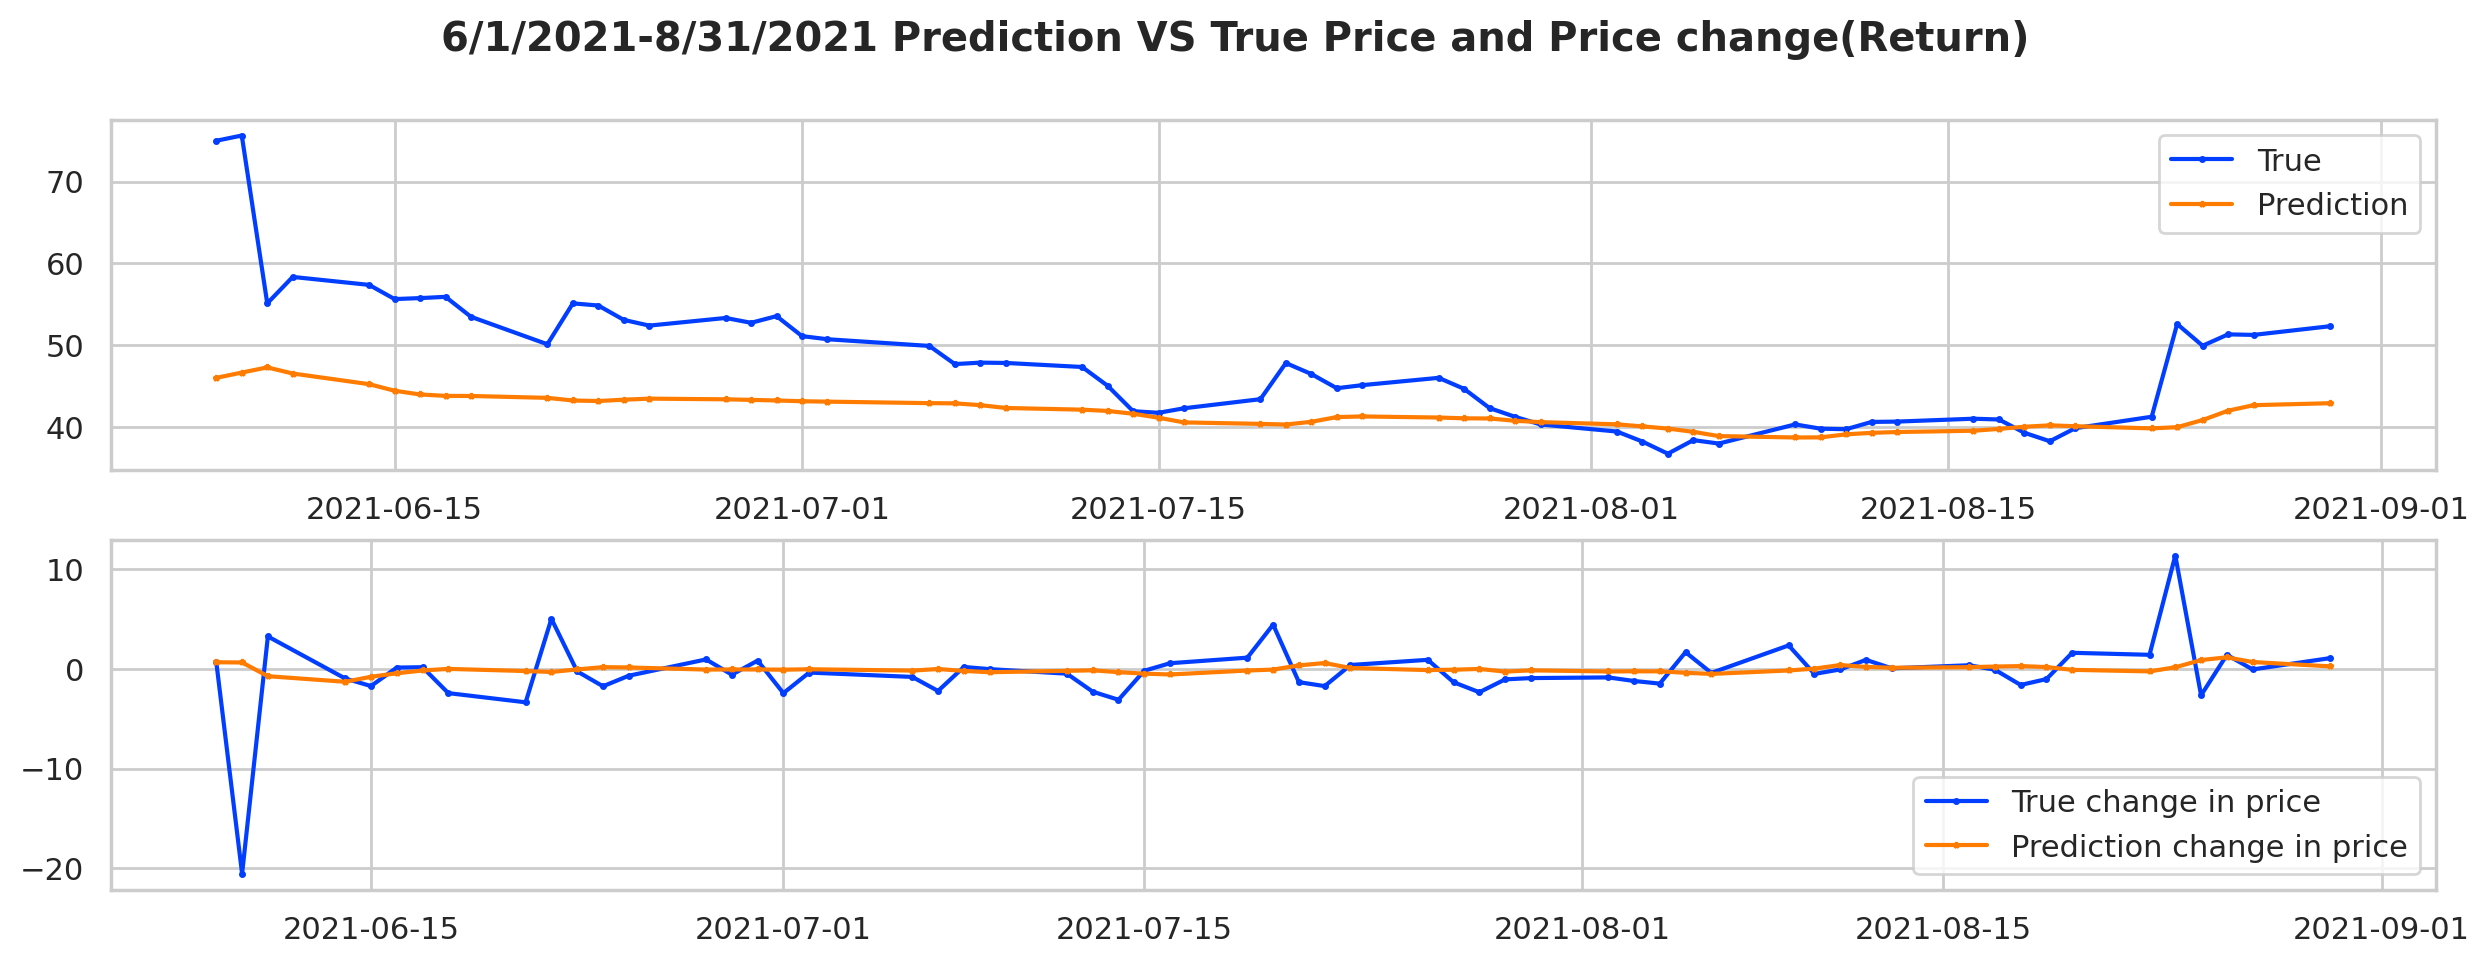

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [ ]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [ ]:
prediction,true_labels=test(inference_loader)
# prediction = prediction[:,0]
# true_labels=true_labels[:,0]
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_train_test_metrics = get_metrics(prediction,true_labels)
baseline_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE      MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  111.233643  10.546736  7.24609  0.207648     0.798761           0.198846   

   Spearman Corr(IC)  
0           0.118692

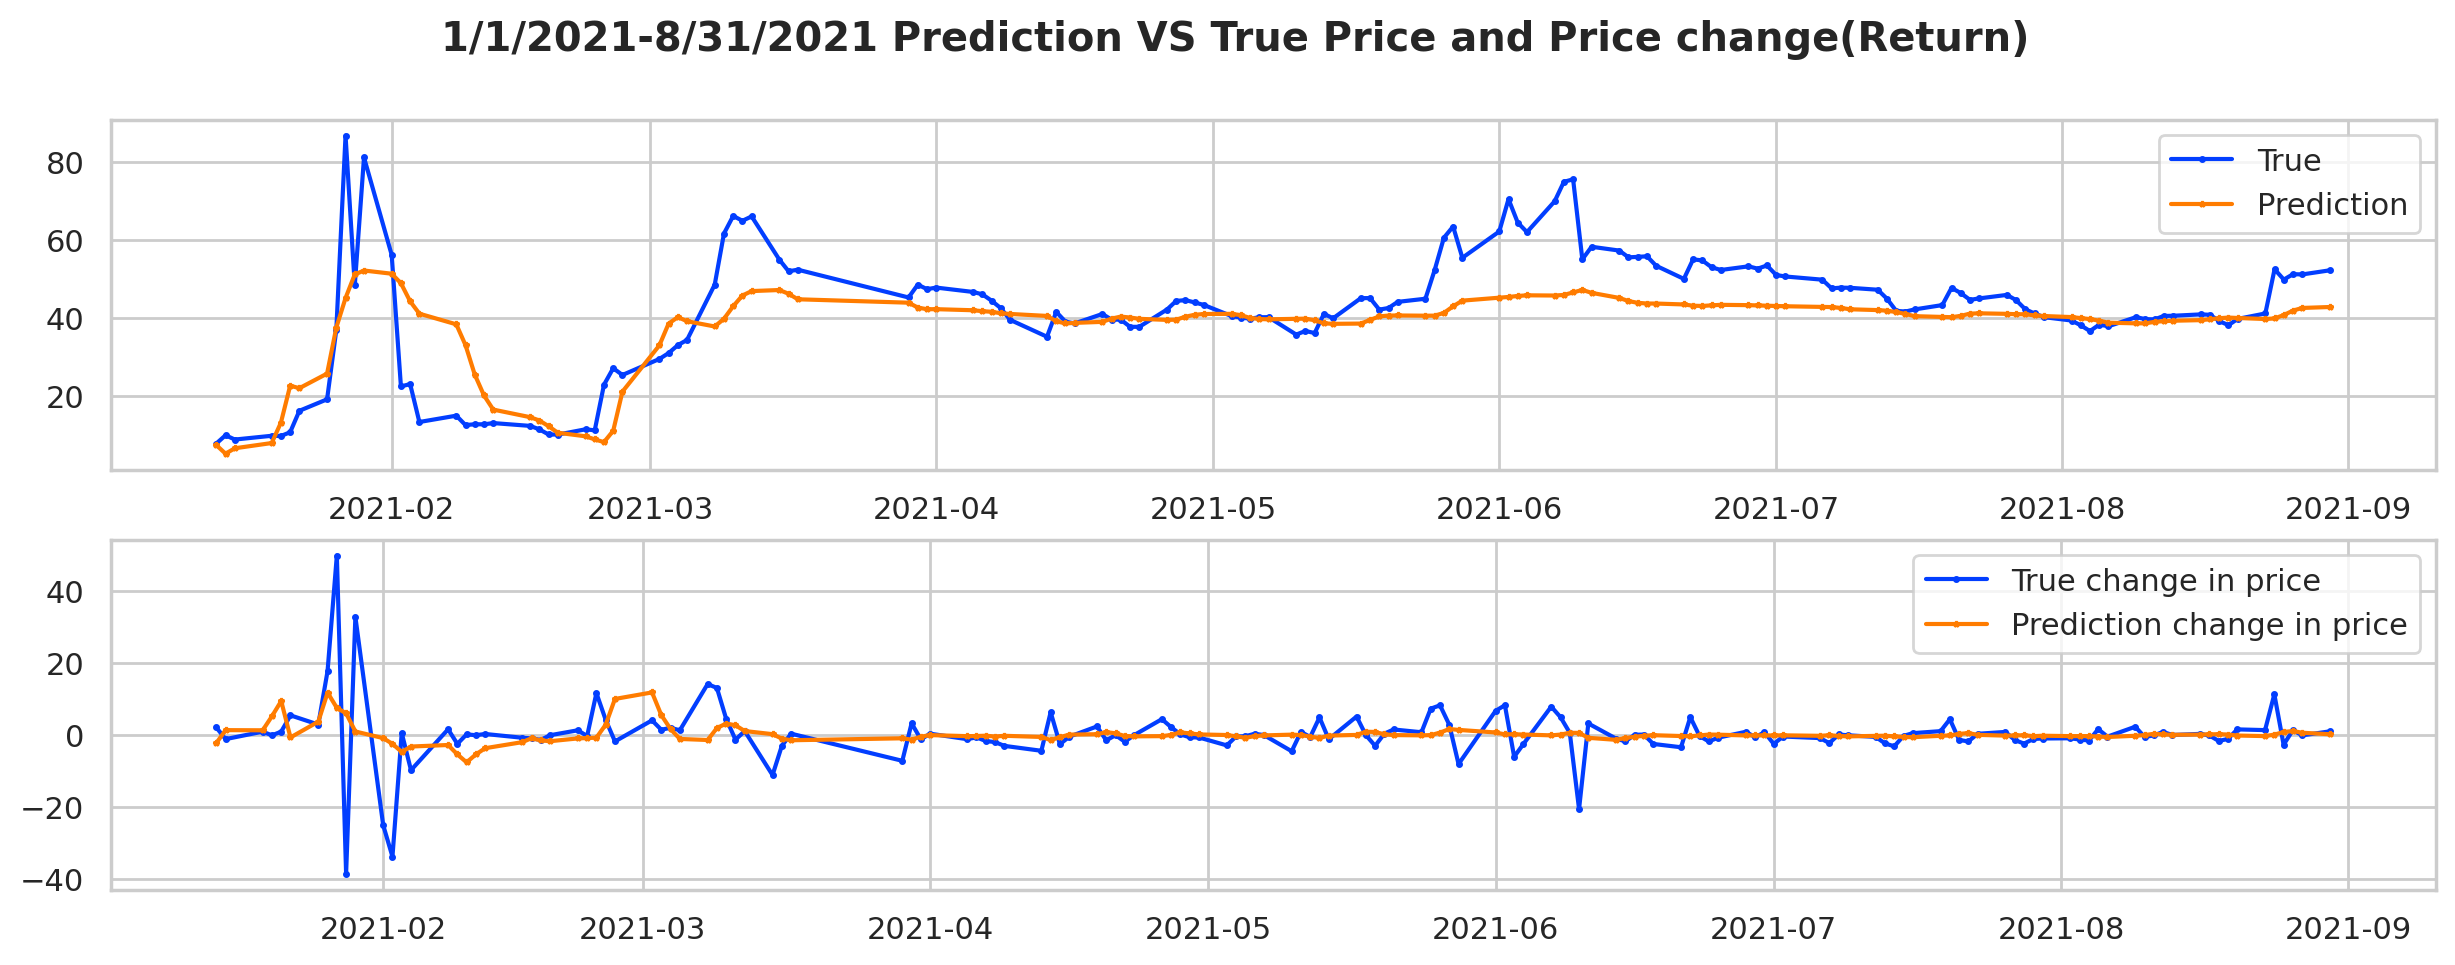

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:],np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore TF-IDF**

### **Combine titles in each day**

In [ ]:
#combine Reddit titles each day to calculate TF-IDF, each day, we only take the first 10k words
df_comb_titles = df[['title','Date']].groupby('Date')['title'].apply('. '.join)
df_comb_titles  = pd.DataFrame(df_comb_titles)
df_comb_titles['title'] = df_comb_titles['title'].apply(lambda x:x[:10000])
df_comb_titles

title
Date                                                         
2021-01-04  short squeeze incoming  rocket  rocket  rocket...
2021-01-05  this convinced me to all in  money_bag gme ext...
2021-01-06  icr conference 11th jan. hey guys we have a fr...
2021-01-11  ryan cohen not being paid. buckle your seatbel...
2021-01-12  questions from a potential investor about game...
...                                                       ...
2021-12-27  ryan cohen on twitter.  rocket  rocket  we had...
2021-12-28  right clicking all the nfts. throw the book at...
2021-12-29  so banks charge overdraft fees when you dont h...
2021-12-30  gamestop is doing something much bigger than j...
2021-12-31  happy new year apes painting by me spot the ea...

[240 rows x 1 columns]

In [ ]:
df_comb_titles['title'].apply(lambda x:len(x)).describe()

count      240.000000
mean      9492.133333
std       2084.785844
min        109.000000
25%      10000.000000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: title, dtype: float64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b')
tfidf_matrix = vectorizer.fit_transform(list(df_comb_titles['title']))
print("TF-IDF shape: ",tfidf_matrix.shape)

dense_matrix = tfidf_matrix.todense()
df_tfidf = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_tfidf

TF-IDF shape:  (240, 18962)


a   aa  aaa  aaaaaaaaand  aaaaaaaand  aaaaaah  aaaaaand  aaaaaaw  \
0    0.000000  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
1    0.091917  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
2    0.094165  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
3    0.000000  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
4    0.101488  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
..        ...  ...  ...          ...         ...      ...       ...      ...   
235  0.146017  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
236  0.123268  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
237  0.147931  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
238  0.115883  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
239  0.167895  0.0  0.0          0.0         0.0      0.0       0.0      0.0   

     aaaaand  aaaaannnnddd  ...  zoos  zuck  zum  zur  zusammen  zwebsites  \
0        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
1        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
2        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
3        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
4        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
..       ...           ...  ...   ...   ...  ...  ...       ...        ...   
235      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
236      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
237      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
238      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
239      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   

     zwiss  zzz  zzzzz  zzzzzap  
0      0.0  0.0    0.0      0.0  
1      0.0  0.0    0.0      0.0  
2      0.0  0.0    0.0      0.0  
3      0.0  0.0    0.0      0.0  
4      0.0  0.0    0.0      0.0  
..     ...  ...    ...      ...  
235    0.0  0.0    0.0      0.0  
236    0.0  0.0    0.0      0.0  
237    0.0  0.0    0.0      0.0  
238    0.0  0.0    0.0      0.0  
239    0.0  0.0    0.0      0.0  

[240 rows x 18962 columns]

In [ ]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)

## **PCA from 19k+dims to 200 dims**

In [ ]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(np.array(dense_matrix))

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio.sum())

# If you want to examine the PCA result as a DataFrame
df_pca = pd.DataFrame(pca_result,columns=['pc'+str(i) for i in range(n_comp)])
df_pca.index = dff.index
df_pca

Explained variance ratio: 0.911298626979222


pc0       pc1       pc2       pc3       pc4       pc5  \
Date                                                                     
2021-01-04  0.734894  0.358163  0.489171 -0.257020 -0.067452 -0.064414   
2021-01-05  0.219626  0.505994 -0.288746  0.087055 -0.400453  0.027756   
2021-01-06  0.288189  0.602619 -0.331833  0.032574 -0.172284 -0.065444   
2021-01-11  0.392884  0.552816 -0.105681 -0.278921  0.120026  0.088933   
2021-01-12  0.160893  0.470392 -0.305268 -0.263927  0.512840  0.260506   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.088646  0.042667  0.082941 -0.076811  0.017228 -0.023061   
2021-12-28 -0.153844  0.027913  0.050069 -0.008562  0.036006  0.037525   
2021-12-29 -0.222644  0.057988  0.019176  0.033354  0.019911  0.008024   
2021-12-30 -0.097990  0.067841  0.033564 -0.005537 -0.071063 -0.026230   
2021-12-31 -0.111395  0.008943 -0.045596 -0.020969  0.042297 -0.006071   

                 pc6       pc7       pc8       pc9  ...     pc190     pc191  \
Date                                                ...                       
2021-01-04 -0.052921 -0.009498  0.021577 -0.016657  ... -0.024142  0.017961   
2021-01-05  0.088216 -0.163889 -0.116160 -0.222089  ...  0.001140  0.000100   
2021-01-06  0.246567 -0.494233  0.524806 -0.103073  ...  0.003400 -0.004656   
2021-01-11  0.037930 -0.208914 -0.370343  0.096948  ... -0.012721 -0.004959   
2021-01-12  0.107920 -0.101122 -0.066890  0.067225  ... -0.010794 -0.002980   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.085963  0.052847 -0.061317  0.030928  ... -0.021752 -0.041062   
2021-12-28  0.094168  0.045029 -0.030768 -0.032640  ... -0.016729  0.021751   
2021-12-29  0.088288  0.008340 -0.026813 -0.008554  ...  0.005724  0.002762   
2021-12-30  0.045113  0.013116 -0.071444 -0.023518  ...  0.059198 -0.033405   
2021-12-31  0.141007  0.072832 -0.016758  0.003938  ...  0.001666  0.042743   

               pc192     pc193     pc194     pc195     pc196     pc197  \
Date                                                                     
2021-01-04  0.009902 -0.013083  0.025213  0.024501 -0.003290 -0.011309   
2021-01-05  0.000440  0.005067  0.001753  0.001943 -0.000476  0.002265   
2021-01-06  0.003874 -0.002300  0.002837  0.004561  0.001885 -0.004665   
2021-01-11 -0.003949 -0.011721  0.002207 -0.007698 -0.003037  0.000097   
2021-01-12 -0.001662  0.014499 -0.010567 -0.004637  0.007513  0.001164   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.019897  0.005108  0.024571 -0.004626 -0.031462 -0.052024   
2021-12-28 -0.029744  0.034547  0.048374 -0.056496  0.015631  0.050494   
2021-12-29 -0.060912 -0.026473  0.084853 -0.064926  0.038461 -0.009470   
2021-12-30  0.029406  0.002873 -0.018273  0.035269 -0.006411  0.000415   
2021-12-31 -0.002717 -0.023162 -0.052390  0.043671 -0.009225  0.028194   

               pc198     pc199  
Date                            
2021-01-04 -0.012390  0.007649  
2021-01-05  0.000501 -0.010652  
2021-01-06 -0.004256 -0.004369  
2021-01-11 -0.006674 -0.002713  
2021-01-12 -0.000085 -0.000115  
...              ...       ...  
2021-12-27  0.057950  0.019580  
2021-12-28  0.030970 -0.080685  
2021-12-29 -0.063638  0.061614  
2021-12-30 -0.048141  0.026087  
2021-12-31 -0.006908 -0.039825  

[240 rows x 200 columns]

In [ ]:
df_full = pd.concat([dff,df_pca],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  price_change       pc0       pc1  ...  \
Date                                                                  ...   
2021-01-04      5.000000  1.000000      0.000000  0.734894  0.358163  ...   
2021-01-05      5.000000  1.000000      0.030000  0.219626  0.505994  ...   
2021-01-06     12.500000  1.000000      0.247500  0.288189  0.602619  ...   
2021-01-11      9.500000  1.250000      0.395000  0.392884  0.552816  ...   
2021-01-12     12.000000  1.500000      0.002500  0.160893  0.470392  ...   
...                  ...       ...           ...       ...       ...  ...   
2021-12-27      0.007576  1.007576     -0.957500 -0.088646  0.042667  ...   
2021-12-28      0.010753  1.005376     -0.462498 -0.153844  0.027913  ...   
2021-12-29      0.010695  1.000000      1.867496 -0.222644  0.057988  ...   
2021-12-30      0.005556  1.022222      0.350002 -0.097990  0.067841  ...   
2021-12-31      0.013889  1.013889     -1.735001 -0.111395  0.008943  ...   

               pc190     pc191     pc192     pc193     pc194     pc195  \
Date                                                                     
2021-01-04 -0.024142  0.017961  0.009902 -0.013083  0.025213  0.024501   
2021-01-05  0.001140  0.000100  0.000440  0.005067  0.001753  0.001943   
2021-01-06  0.003400 -0.004656  0.003874 -0.002300  0.002837  0.004561   
2021-01-11 -0.012721 -0.004959 -0.003949 -0.011721  0.002207 -0.007698   
2021-01-12 -0.010794 -0.002980 -0.001662  0.014499 -0.010567 -0.004637   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.021752 -0.041062  0.019897  0.005108  0.024571 -0.004626   
2021-12-28 -0.016729  0.021751 -0.029744  0.034547  0.048374 -0.056496   
2021-12-29  0.005724  0.002762 -0.060912 -0.026473  0.084853 -0.064926   
2021-12-30  0.059198 -0.033405  0.029406  0.002873 -0.018273  0.035269   
2021-12-31  0.001666  0.042743 -0.002717 -0.023162 -0.052390  0.043671   

               pc196     pc197     pc198     pc199  
Date                                                
2021-01-04 -0.003290 -0.011309 -0.012390  0.007649  
2021-01-05 -0.000476  0.002265  0.000501 -0.010652  
2021-01-06  0.001885 -0.004665 -0.004256 -0.004369  
2021-01-11 -0.003037  0.000097 -0.006674 -0.002713  
2021-01-12  0.007513  0.001164 -0.000085 -0.000115  
...              ...       ...       ...       ...  
2021-12-27 -0.031462 -0.052024  0.057950  0.019580  
2021-12-28  0.015631  0.050494  0.030970 -0.080685  
2021-12-29  0.038461 -0.009470 -0.063638  0.061614  
2021-12-30 -0.006411  0.000415 -0.048141  0.026087  
2021-12-31 -0.009225  0.028194 -0.006908 -0.039825  

[240 rows x 208 columns]

## **Correlation between TF-IDF(PCA) & Price**

<Axes: >

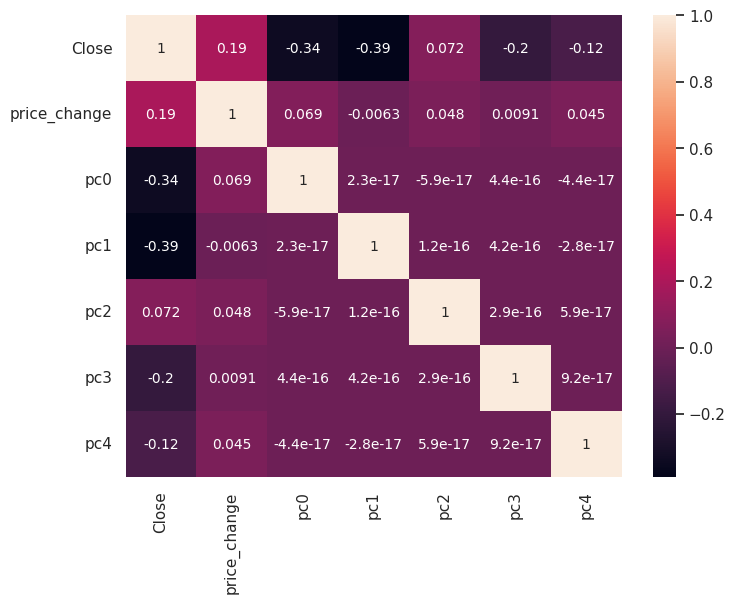

In [ ]:
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(df_full[['Close','price_change','pc0','pc1','pc2','pc3','pc4']].corr(),annot=True,annot_kws={"size":10})

Text(0.5, 1.0, 'GameStop(GME) stock price VS Principal Component')

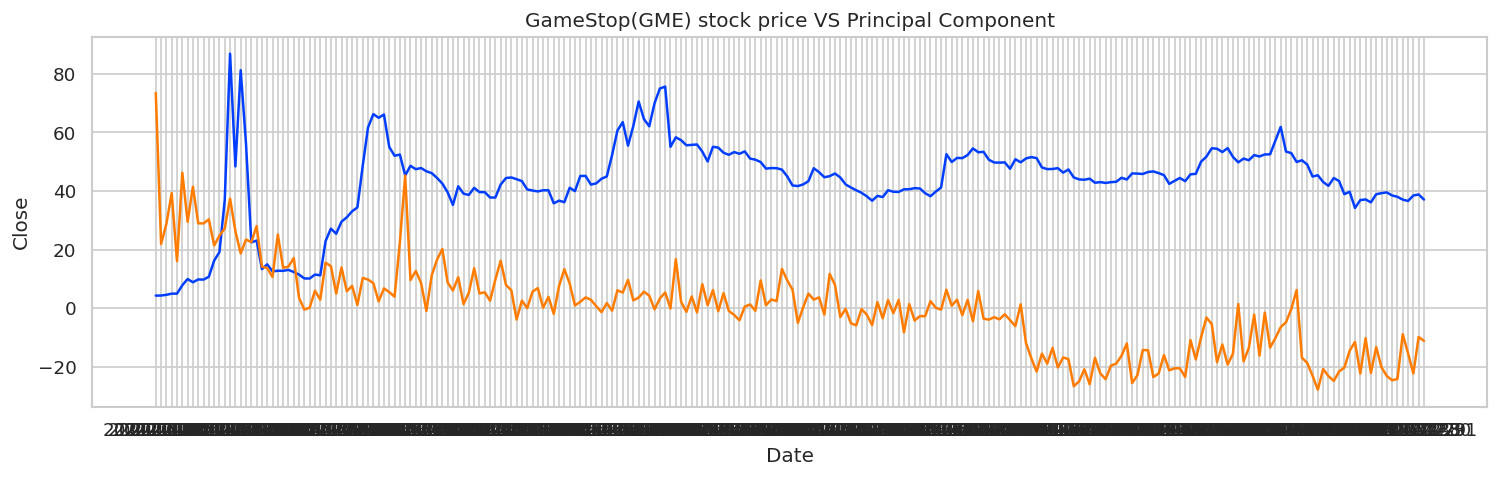

In [ ]:
plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(df_full['Close'])
sns.lineplot(df_full['pc0']*100)
plt.title("GameStop(GME) stock price VS Principal Component")

## **Time Series with TF-IDF features**

In [ ]:
df_ts=df_full.copy().reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts[df_ts.columns.difference(['Date','score','price_change','num_comments','sentiment'])]
df_ts #dimension should be 5(open, high, low, close, volume) +200 =205

Close       High        Low       Open      Volume       pc0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0  0.734894   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0  0.219626   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0  0.288189   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0  0.392884   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0  0.160893   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.088646   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.153844   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.222644   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.097990   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.111395   

                 pc1      pc10     pc100     pc101  ...      pc90      pc91  \
Date                                                ...                       
2021-01-04  0.358163  0.002888  0.002220  0.008139  ...  0.002731 -0.010923   
2021-01-05  0.505994 -0.457191  0.004758 -0.000649  ...  0.000513  0.003913   
2021-01-06  0.602619  0.347340  0.013211 -0.001490  ...  0.011074  0.000712   
2021-01-11  0.552816 -0.296988 -0.005265  0.003217  ... -0.003271  0.005558   
2021-01-12  0.470392 -0.025387 -0.004219  0.002586  ... -0.007649  0.018718   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.042667 -0.009350  0.059193  0.037102  ...  0.041754  0.008974   
2021-12-28  0.027913  0.022973  0.020061  0.075197  ...  0.001225 -0.009702   
2021-12-29  0.057988 -0.000974 -0.000428 -0.004710  ... -0.000307 -0.010252   
2021-12-30  0.067841  0.005002 -0.039101 -0.026632  ...  0.057475 -0.020155   
2021-12-31  0.008943  0.017251 -0.001850 -0.018361  ... -0.012572  0.012423   

                pc92      pc93      pc94      pc95      pc96      pc97  \
Date                                                                     
2021-01-04 -0.010152  0.005708  0.006683  0.002237  0.013933  0.010916   
2021-01-05  0.002825  0.006413 -0.011646  0.000675  0.011406  0.007707   
2021-01-06  0.019777  0.011955  0.003482  0.009526 -0.005555  0.002361   
2021-01-11  0.002105  0.003510  0.008725  0.004992  0.005911  0.005197   
2021-01-12  0.010232  0.005125 -0.004989 -0.007948  0.019242 -0.003622   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.023727  0.045788  0.010726 -0.038746 -0.012601  0.020302   
2021-12-28 -0.033694  0.072848 -0.025157 -0.043711 -0.020616  0.032275   
2021-12-29  0.019144 -0.034178 -0.001528 -0.015458 -0.030709 -0.059438   
2021-12-30 -0.002381 -0.058215  0.015667 -0.019137  0.090191  0.016868   
2021-12-31 -0.028427  0.020456 -0.017277 -0.075677 -0.021766 -0.071040   

                pc98      pc99  
Date                            
2021-01-04  0.000333  0.010900  
2021-01-05 -0.009012 -0.001796  
2021-01-06 -0.003882  0.012922  
2021-01-11  0.021027 -0.017001  
2021-01-12 -0.029693 -0.005446  
...              ...       ...  
2021-12-27 -0.099718  0.034520  
2021-12-28  0.011564  0.013387  
2021-12-29 -0.026171  0.008769  
2021-12-30  0.028326 -0.022261  
2021-12-31 -0.107605  0.039789  

[240 rows x 205 columns]

# **Training with Tf-idf**

### **Train Test Split**

In [ ]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [ ]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'pc0', 'pc1', 'pc10', 'pc100',
       'pc101',
       ...
       'pc90', 'pc91', 'pc92', 'pc93', 'pc94', 'pc95', 'pc96', 'pc97', 'pc98',
       'pc99'],
      dtype='object', length=205)


((70, 205), (20, 205), (65, 205))

In [ ]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [ ]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 205])
x:  tensor([0.5153, 0.3648, 0.1450, 0.4681, 0.3405])
y_train:  tensor([0.3648, 0.1450, 0.4681, 0.3405, 0.3183])


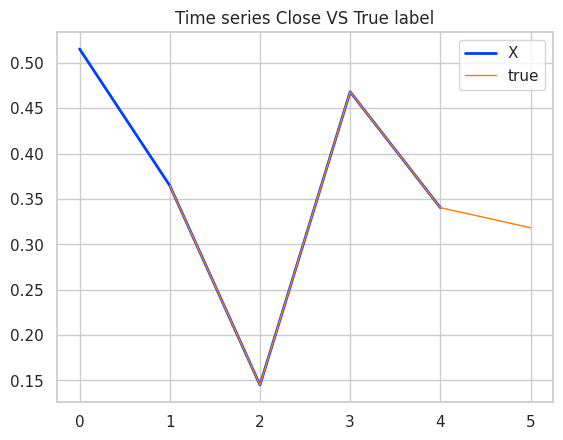

In [ ]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [ ]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)


In [ ]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([0.7834, 0.7265, 0.6955, 0.6128, 0.5153], device='cuda:0') tensor([0.7265, 0.6955, 0.6128, 0.5153, 0.3648], device='cuda:0')
x shape: torch.Size([64, 5, 205]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  1.472512M  1.468416M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------------
 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [ ]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [ ]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9443	 Learning Rate 0.0020000	 Validation Loss 0.5336

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8052	 Learning Rate 0.0016000	 Validation Loss 0.4610

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4921	 Learning Rate 0.0012800	 Validation Loss 0.3987

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2013	 Learning Rate 0.0010240	 Validation Loss 0.4524

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3797	 Learning Rate 0.0008192	 Validation Loss 0.4897

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1527	 Learning Rate 0.0006554	 Validation Loss 0.5067

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1028	 Learning Rate 0.0005243	 Validation Loss 0.5149

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0923	 Learning Rate 0.0004194	 Validation Loss 0.5207

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1184	 Learning Rate 0.0003355	 Validation Loss 0.5253

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1342	 Learning Rate 0.0002684	 Validation Loss 0.5288

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1282	 Learning Rate 0.0002147	 Validation Loss 0.5321

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1178	 Learning Rate 0.0001718	 Validation Loss 0.5351

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1000	 Learning Rate 0.0001374	 Validation Loss 0.5376

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0914	 Learning Rate 0.0001100	 Validation Loss 0.5397

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0849	 Learning Rate 0.0000880	 Validation Loss 0.5414

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0815	 Learning Rate 0.0000704	 Validation Loss 0.5431

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1026	 Learning Rate 0.0000563	 Validation Loss 0.5444

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0762	 Learning Rate 0.0000450	 Validation Loss 0.5454

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0803	 Learning Rate 0.0000360	 Validation Loss 0.5463

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0796	 Learning Rate 0.0000288	 Validation Loss 0.5471

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0690	 Learning Rate 0.0000231	 Validation Loss 0.5478

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0791	 Learning Rate 0.0000184	 Validation Loss 0.5484

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0815	 Learning Rate 0.0000148	 Validation Loss 0.5489

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0757	 Learning Rate 0.0000118	 Validation Loss 0.5493

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0554	 Learning Rate 0.0000094	 Validation Loss 0.5496

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0678	 Learning Rate 0.0000076	 Validation Loss 0.5498

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0551	 Learning Rate 0.0000060	 Validation Loss 0.5500

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0858	 Learning Rate 0.0000048	 Validation Loss 0.5502

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0821	 Learning Rate 0.0000039	 Validation Loss 0.5503

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0593	 Learning Rate 0.0000031	 Validation Loss 0.5504

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0814	 Learning Rate 0.0000025	 Validation Loss 0.5504

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0828	 Learning Rate 0.0000020	 Validation Loss 0.5505

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0761	 Learning Rate 0.0000016	 Validation Loss 0.5505

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0761	 Learning Rate 0.0000013	 Validation Loss 0.5506

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0682	 Learning Rate 0.0000010	 Validation Loss 0.5506

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0544	 Learning Rate 0.0000008	 Validation Loss 0.5506

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0648	 Learning Rate 0.0000006	 Validation Loss 0.5507

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0842	 Learning Rate 0.0000005	 Validation Loss 0.5507

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0581	 Learning Rate 0.0000004	 Validation Loss 0.5507

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0902	 Learning Rate 0.0000003	 Validation Loss 0.5507

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0731	 Learning Rate 0.0000003	 Validation Loss 0.5507

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0730	 Learning Rate 0.0000002	 Validation Loss 0.5507

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0647	 Learning Rate 0.0000002	 Validation Loss 0.5507

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0771	 Learning Rate 0.0000001	 Validation Loss 0.5507

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0595	 Learning Rate 0.0000001	 Validation Loss 0.5507

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0633	 Learning Rate 0.0000001	 Validation Loss 0.5507

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0595	 Learning Rate 0.0000001	 Validation Loss 0.5507

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0655	 Learning Rate 0.0000001	 Validation Loss 0.5507

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0734	 Learning Rate 0.0000000	 Validation Loss 0.5507

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0665	 Learning Rate 0.0000000	 Validation Loss 0.5507


Text(0.5, 1.0, 'Validation loss')

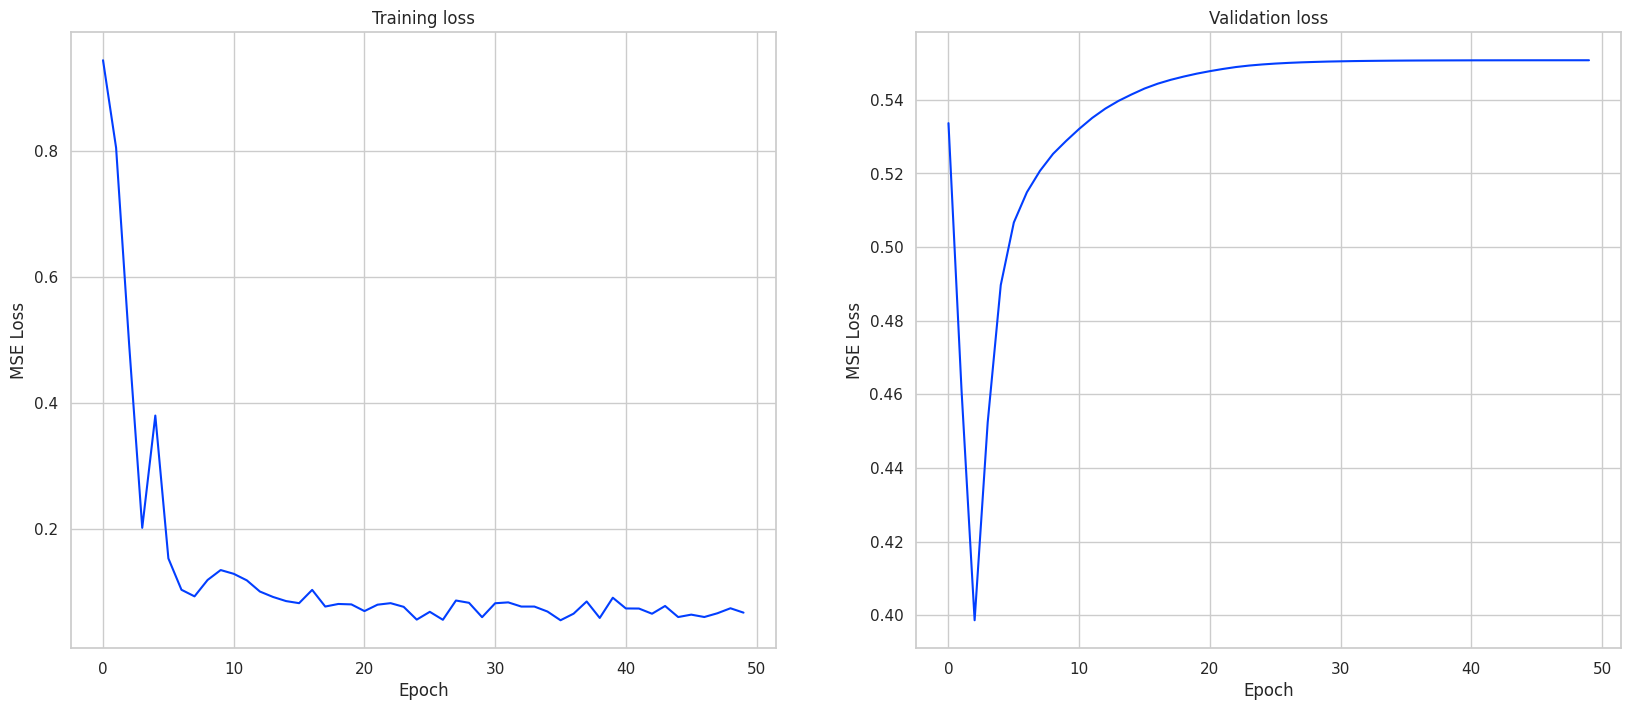

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [ ]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_test_metrics=get_metrics(prediction,true_labels)
tfidf_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE       RMSE        MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  239.582047  15.478438  14.070969  0.417722     0.633061           0.106105   

   Spearman Corr(IC)  
0           0.082686

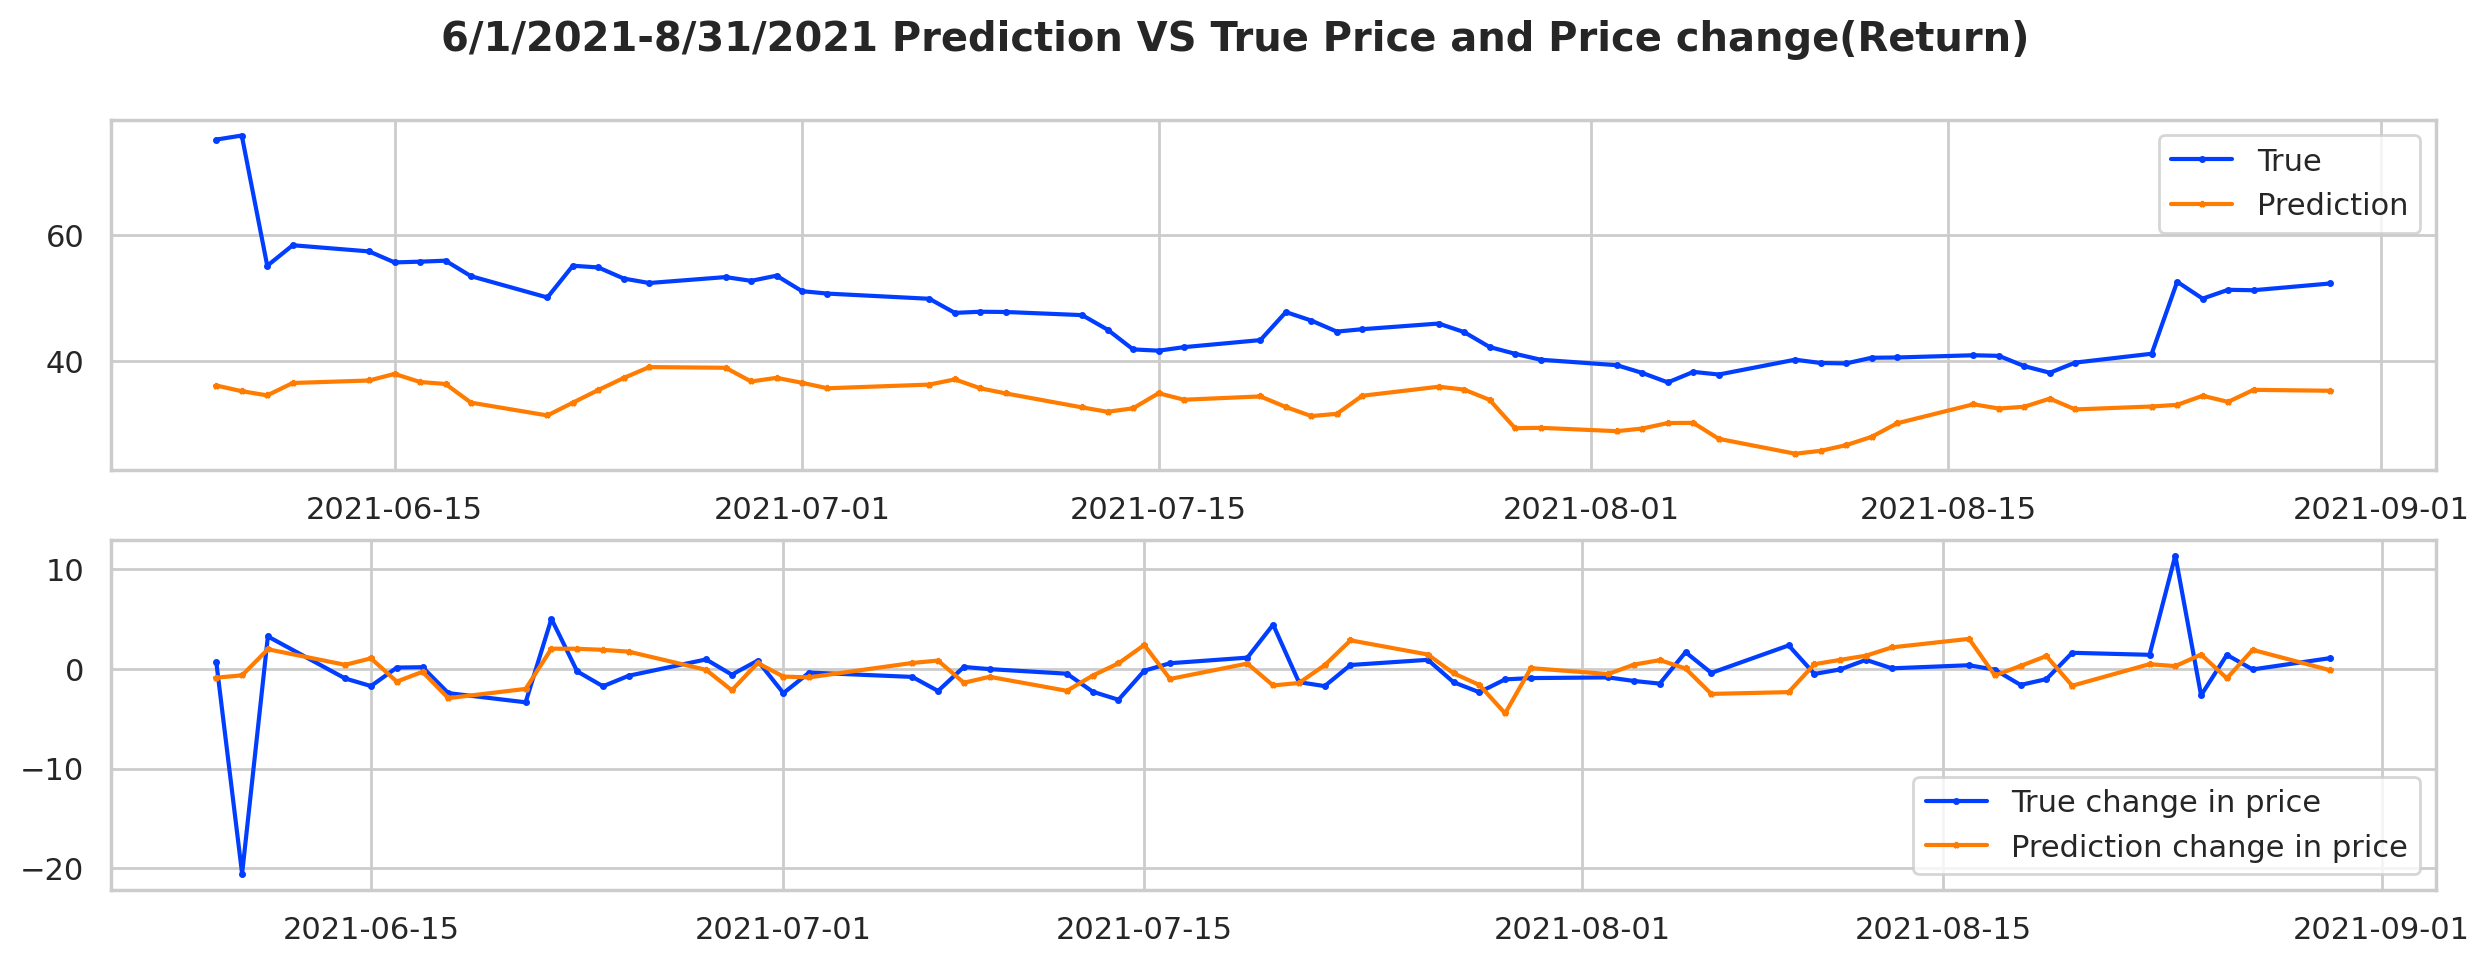

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [ ]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [ ]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_train_test_metrics=get_metrics(prediction,true_labels)
tfidf_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE     MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  163.078217  12.770208  9.3477  0.281204     0.775231              0.592   

   Spearman Corr(IC)  
0           0.349812

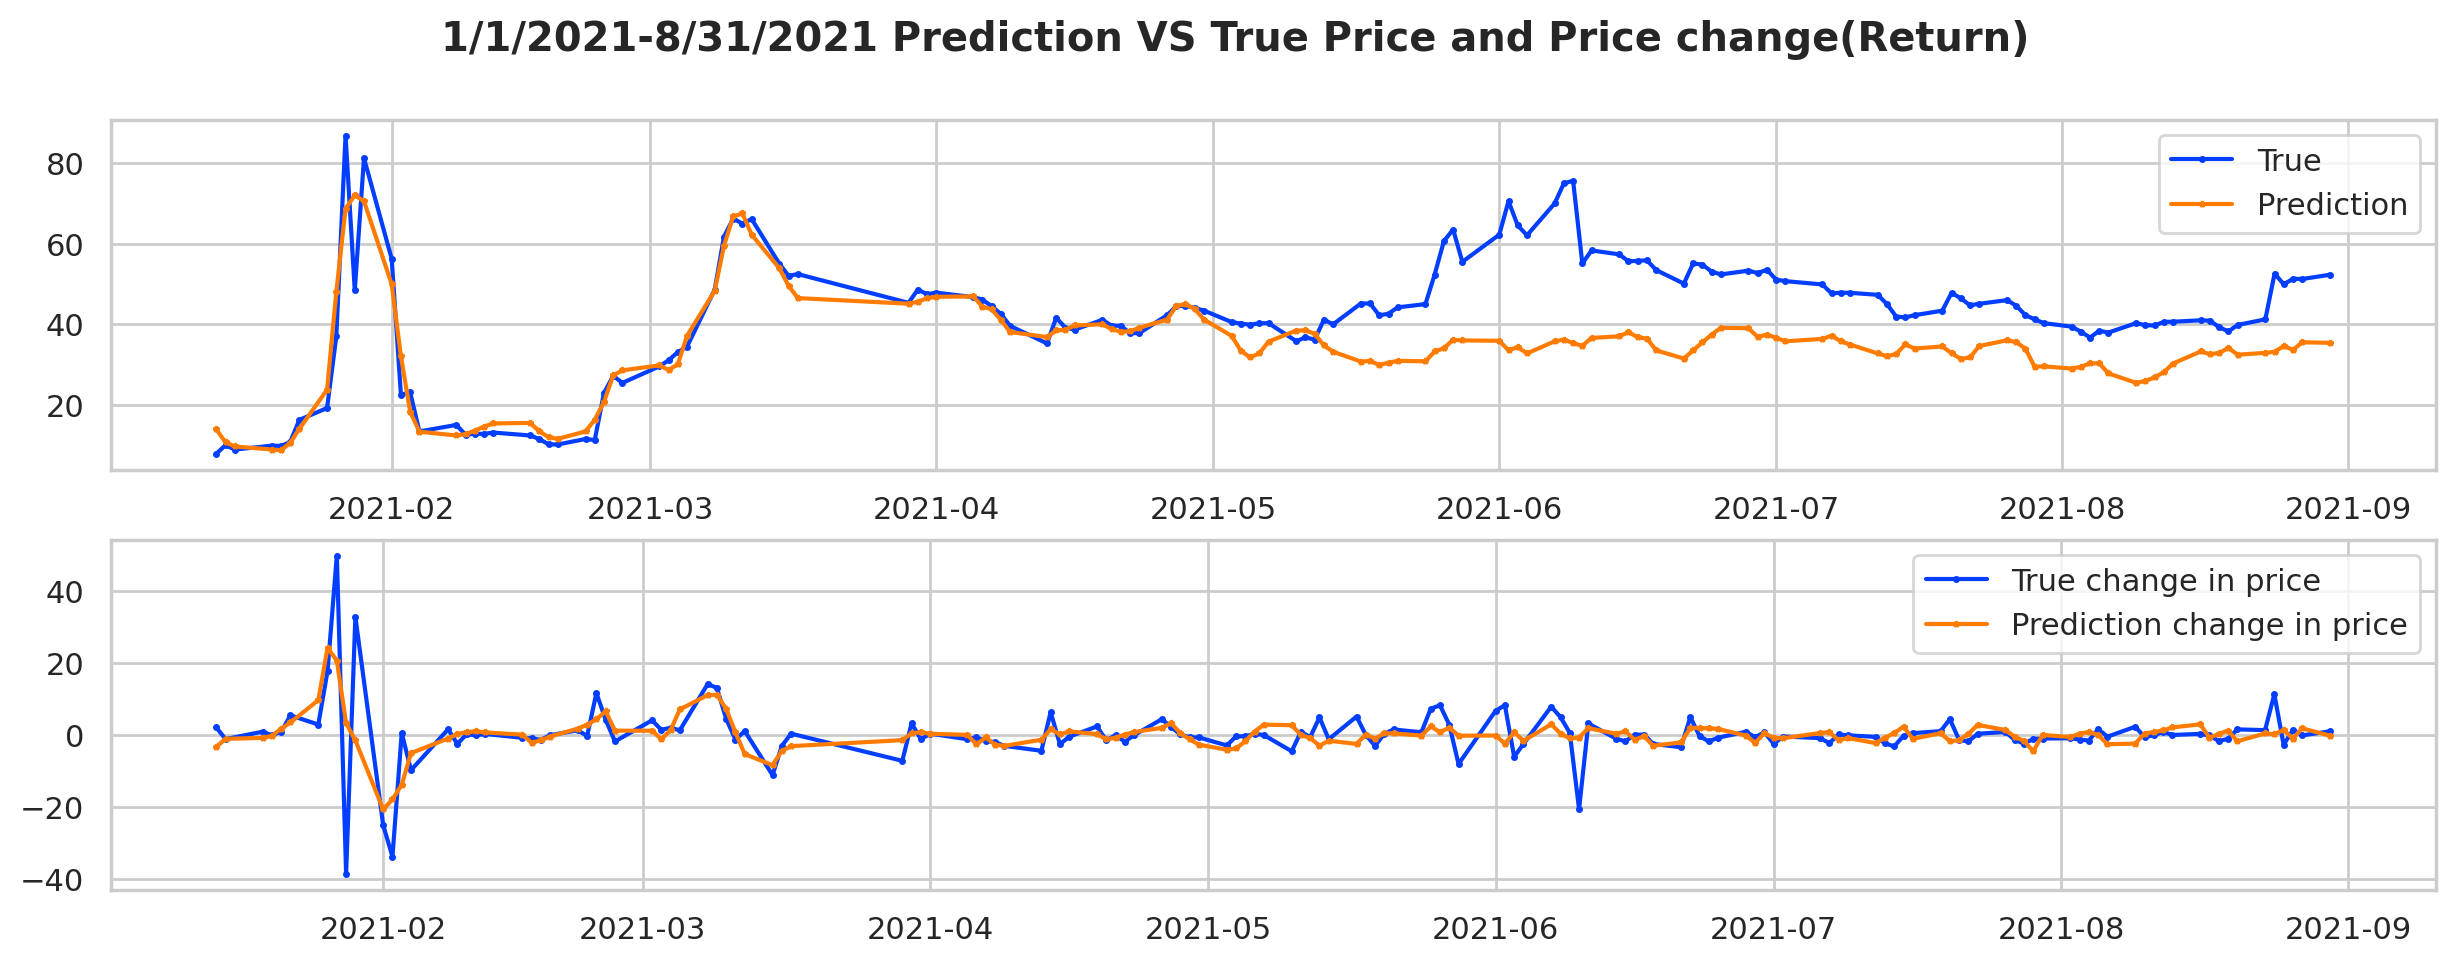

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore Bert Embeddings**

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

## **Load my fine-tuned Bert to generate embeddings**

In [ ]:
def tokenize(x,max_length=50):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=max_length,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )
  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("Shape of tokenized vector:",df_vec.shape)
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

Shape of tokenized vector: (65033,)
shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [ ]:
bert_model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
bert_model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index].to(device), self.token_type_ids[index].to(device), self.att_mask[index].to(device))

In [ ]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 256,
    shuffle=False
)
len(inference_data)
for X in inference_loader:
  print(len(X))
  print(X[0].shape, X[1].shape, X[2].shape)
  break
bert_model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.shape

3
torch.Size([256, 50]) torch.Size([256, 50]) torch.Size([256, 50])


torch.Size([256, 768])

In [ ]:
embeddings = []
for X in tqdm(inference_loader, "inferencing..."):
  with torch.no_grad():
    res = bert_model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.cpu().detach().numpy()
    # print(res.shape)
    embeddings .append(res)
    del X
    gc.collect()
    torch.cuda.empty_cache()

embeddings = np.vstack(embeddings )
embeddings.shape

inferencing...:   0%|          | 0/255 [00:00<?, ?it/s]

(65033, 768)

## **Combine Time Series with Bert Embeddings.**

In [338]:
df_embeddings = pd.DataFrame(embeddings,columns=['dim'+str(i) for i in range(embeddings.shape[-1])])
df_embeddings['Date'] = df['Date']
df_embeddings = df_embeddings.groupby('Date').mean()
df_embeddings

dim0      dim1      dim2      dim3      dim4      dim5  \
Date                                                                     
2021-01-04 -0.839527 -0.424083 -0.761567  0.662155  0.450761 -0.177779   
2021-01-05 -0.645647 -0.214557  0.052024  0.301909 -0.188323  0.077009   
2021-01-06 -0.628741 -0.299113 -0.654147  0.409663  0.445411 -0.050049   
2021-01-11 -0.802747 -0.291301 -0.455577  0.563209  0.237437 -0.076465   
2021-01-12 -0.769426 -0.150443 -0.014803  0.306195 -0.156165 -0.082009   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.722376 -0.209015 -0.062432  0.457428  0.084856 -0.062181   
2021-12-28 -0.714688 -0.201411 -0.050750  0.449622  0.071735 -0.066485   
2021-12-29 -0.700761 -0.212115 -0.081491  0.453946  0.075147 -0.069935   
2021-12-30 -0.717502 -0.209257 -0.104970  0.453192  0.087345 -0.065931   
2021-12-31 -0.743491 -0.219027 -0.034612  0.458078  0.051005 -0.056619   

                dim6      dim7      dim8      dim9  ...    dim758    dim759  \
Date                                                ...                       
2021-01-04  0.661404  0.180796 -0.404010 -0.999967  ...  0.349083  0.094895   
2021-01-05  0.432468  0.036705  0.245787 -0.998497  ...  0.288688  0.605945   
2021-01-06  0.378659  0.173903 -0.174406 -0.997786  ...  0.396931  0.087815   
2021-01-11  0.544653  0.194068 -0.086913 -0.999832  ...  0.358911  0.071618   
2021-01-12  0.612291  0.131569  0.166596 -0.999605  ...  0.380514  0.499363   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.531216  0.100458  0.160203 -0.997727  ...  0.296191  0.367086   
2021-12-28  0.516901  0.097359  0.197101 -0.996790  ...  0.287137  0.422395   
2021-12-29  0.521564  0.105015  0.184587 -0.995516  ...  0.295643  0.417410   
2021-12-30  0.518996  0.116407  0.190097 -0.997788  ...  0.294923  0.404394   
2021-12-31  0.581057  0.122293  0.223379 -0.997221  ...  0.298395  0.358334   

              dim760    dim761    dim762    dim763    dim764    dim765  \
Date                                                                     
2021-01-04  0.929867  0.693200  0.033616  0.395849  0.379404 -0.602982   
2021-01-05 -0.044362  0.676697  0.785801  0.708676  0.422682 -0.098632   
2021-01-06  0.784068  0.727849 -0.380828  0.351390  0.450142 -0.663287   
2021-01-11  0.611937  0.734785  0.055054  0.554327  0.425337 -0.025344   
2021-01-12  0.112339  0.703219  0.009969  0.433367  0.419007  0.258986   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.363224  0.763551  0.138911  0.620201  0.392103 -0.042246   
2021-12-28  0.327443  0.755344  0.174869  0.628477  0.389487 -0.055540   
2021-12-29  0.330118  0.746983  0.183991  0.601642  0.400625 -0.087555   
2021-12-30  0.345519  0.756193  0.155692  0.623366  0.397987 -0.095204   
2021-12-31  0.338283  0.781611  0.239338  0.663899  0.393651 -0.005101   

              dim766    dim767  
Date                            
2021-01-04 -0.601221  0.744309  
2021-01-05 -0.463653  0.738352  
2021-01-06 -0.467869  0.636216  
2021-01-11 -0.559318  0.834198  
2021-01-12 -0.452421  0.703244  
...              ...       ...  
2021-12-27 -0.501933  0.792294  
2021-12-28 -0.488856  0.782926  
2021-12-29 -0.504970  0.786035  
2021-12-30 -0.494687  0.788137  
2021-12-31 -0.511075  0.815565  

[240 rows x 768 columns]

In [339]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
df_full = pd.concat([dff, df_embeddings],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score      dim0      dim1      dim2  ...  \
Date                                                              ...   
2021-01-04      5.000000  1.000000 -0.839527 -0.424083 -0.761567  ...   
2021-01-05      5.000000  1.000000 -0.645647 -0.214557  0.052024  ...   
2021-01-06     12.500000  1.000000 -0.628741 -0.299113 -0.654147  ...   
2021-01-11      9.500000  1.250000 -0.802747 -0.291301 -0.455577  ...   
2021-01-12     12.000000  1.500000 -0.769426 -0.150443 -0.014803  ...   
...                  ...       ...       ...       ...       ...  ...   
2021-12-27      0.007576  1.007576 -0.722376 -0.209015 -0.062432  ...   
2021-12-28      0.010753  1.005376 -0.714688 -0.201411 -0.050750  ...   
2021-12-29      0.010695  1.000000 -0.700761 -0.212115 -0.081491  ...   
2021-12-30      0.005556  1.022222 -0.717502 -0.209257 -0.104970  ...   
2021-12-31      0.013889  1.013889 -0.743491 -0.219027 -0.034612  ...   

              dim758    dim759    dim760    dim761    dim762    dim763  \
Date                                                                     
2021-01-04  0.349083  0.094895  0.929867  0.693200  0.033616  0.395849   
2021-01-05  0.288688  0.605945 -0.044362  0.676697  0.785801  0.708676   
2021-01-06  0.396931  0.087815  0.784068  0.727849 -0.380828  0.351390   
2021-01-11  0.358911  0.071618  0.611937  0.734785  0.055054  0.554327   
2021-01-12  0.380514  0.499363  0.112339  0.703219  0.009969  0.433367   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.296191  0.367086  0.363224  0.763551  0.138911  0.620201   
2021-12-28  0.287137  0.422395  0.327443  0.755344  0.174869  0.628477   
2021-12-29  0.295643  0.417410  0.330118  0.746983  0.183991  0.601642   
2021-12-30  0.294923  0.404394  0.345519  0.756193  0.155692  0.623366   
2021-12-31  0.298395  0.358334  0.338283  0.781611  0.239338  0.663899   

              dim764    dim765    dim766    dim767  
Date                                                
2021-01-04  0.379404 -0.602982 -0.601221  0.744309  
2021-01-05  0.422682 -0.098632 -0.463653  0.738352  
2021-01-06  0.450142 -0.663287 -0.467869  0.636216  
2021-01-11  0.425337 -0.025344 -0.559318  0.834198  
2021-01-12  0.419007  0.258986 -0.452421  0.703244  
...              ...       ...       ...       ...  
2021-12-27  0.392103 -0.042246 -0.501933  0.792294  
2021-12-28  0.389487 -0.055540 -0.488856  0.782926  
2021-12-29  0.400625 -0.087555 -0.504970  0.786035  
2021-12-30  0.397987 -0.095204 -0.494687  0.788137  
2021-12-31  0.393651 -0.005101 -0.511075  0.815565  

[240 rows x 775 columns]

In [340]:
# df_ts=df_full[df_full.columns.difference(['Date','num_comments','score'])].reset_index()
df_ts = df_full.drop(columns=['num_comments', 'score']).reset_index()
# df_ts=df_full.reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
# df_ts['sentiment'] = df_sentiment['sentiment']
df_ts.index=df_ts['Date']
df_ts = df_ts.drop(columns='Date')
df_ts

Close       High        Low       Open      Volume      dim0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0 -0.839527   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0 -0.645647   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0 -0.628741   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0 -0.802747   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0 -0.769426   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.722376   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.714688   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.700761   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.717502   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.743491   

                dim1      dim2      dim3      dim4  ...    dim758    dim759  \
Date                                                ...                       
2021-01-04 -0.424083 -0.761567  0.662155  0.450761  ...  0.349083  0.094895   
2021-01-05 -0.214557  0.052024  0.301909 -0.188323  ...  0.288688  0.605945   
2021-01-06 -0.299113 -0.654147  0.409663  0.445411  ...  0.396931  0.087815   
2021-01-11 -0.291301 -0.455577  0.563209  0.237437  ...  0.358911  0.071618   
2021-01-12 -0.150443 -0.014803  0.306195 -0.156165  ...  0.380514  0.499363   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27 -0.209015 -0.062432  0.457428  0.084856  ...  0.296191  0.367086   
2021-12-28 -0.201411 -0.050750  0.449622  0.071735  ...  0.287137  0.422395   
2021-12-29 -0.212115 -0.081491  0.453946  0.075147  ...  0.295643  0.417410   
2021-12-30 -0.209257 -0.104970  0.453192  0.087345  ...  0.294923  0.404394   
2021-12-31 -0.219027 -0.034612  0.458078  0.051005  ...  0.298395  0.358334   

              dim760    dim761    dim762    dim763    dim764    dim765  \
Date                                                                     
2021-01-04  0.929867  0.693200  0.033616  0.395849  0.379404 -0.602982   
2021-01-05 -0.044362  0.676697  0.785801  0.708676  0.422682 -0.098632   
2021-01-06  0.784068  0.727849 -0.380828  0.351390  0.450142 -0.663287   
2021-01-11  0.611937  0.734785  0.055054  0.554327  0.425337 -0.025344   
2021-01-12  0.112339  0.703219  0.009969  0.433367  0.419007  0.258986   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.363224  0.763551  0.138911  0.620201  0.392103 -0.042246   
2021-12-28  0.327443  0.755344  0.174869  0.628477  0.389487 -0.055540   
2021-12-29  0.330118  0.746983  0.183991  0.601642  0.400625 -0.087555   
2021-12-30  0.345519  0.756193  0.155692  0.623366  0.397987 -0.095204   
2021-12-31  0.338283  0.781611  0.239338  0.663899  0.393651 -0.005101   

              dim766    dim767  
Date                            
2021-01-04 -0.601221  0.744309  
2021-01-05 -0.463653  0.738352  
2021-01-06 -0.467869  0.636216  
2021-01-11 -0.559318  0.834198  
2021-01-12 -0.452421  0.703244  
...              ...       ...  
2021-12-27 -0.501933  0.792294  
2021-12-28 -0.488856  0.782926  
2021-12-29 -0.504970  0.786035  
2021-12-30 -0.494687  0.788137  
2021-12-31 -0.511075  0.815565  

[240 rows x 773 columns]

# **Training with Bert embeddings**

### **Train Test Split**

In [341]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [342]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'dim0', 'dim1', 'dim2',
       'dim3', 'dim4',
       ...
       'dim758', 'dim759', 'dim760', 'dim761', 'dim762', 'dim763', 'dim764',
       'dim765', 'dim766', 'dim767'],
      dtype='object', length=773)


((70, 773), (20, 773), (65, 773))

In [343]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [367]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 773])
x:  tensor([0.3183, 0.4408, 0.3669, 0.3667, 0.2738])
y_train:  tensor([0.4408, 0.3669, 0.3667, 0.2738, 0.2739])


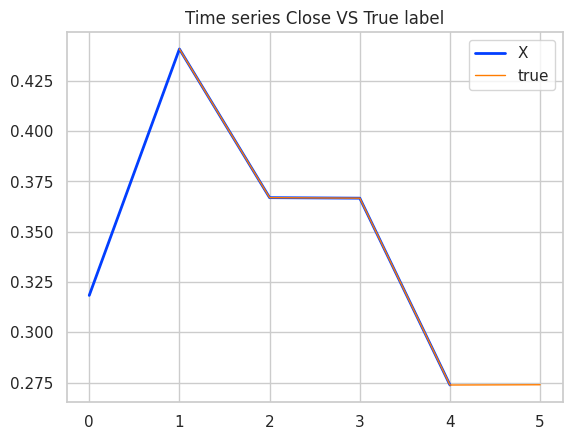

In [404]:
config = {
  'batch_size': 64,
  'lr':1e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [405]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )
        # self.linear_scale = nn.Linear(2,1)
        # self.linear_out = nn.Linear(context_len*d_model, output_dim)

    def forward(self, x):
        return self.model(x) #+ x[:,:,0:1]
        # return self.linear_out(self.model(x).flatten(1)).unsqueeze(1) #+ x[:,:,0:1]
        # return self.linear_scale(torch.cat([self.model(x) , x[:,:,0:1]],dim=-1))


In [406]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-1.0567, -1.0697, -0.4784, -0.2631, -0.3515], device='cuda:0') tensor([-1.0697, -0.4784, -0.2631, -0.3515, -0.1435], device='cuda:0')
x shape: torch.Size([64, 5, 773]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  2.635776M   2.63168M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
-------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [407]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [408]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [409]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9248	 Learning Rate 0.0010000	 Validation Loss 0.3973

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8191	 Learning Rate 0.0008000	 Validation Loss 0.2696

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7063	 Learning Rate 0.0006400	 Validation Loss 0.2083

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.6139	 Learning Rate 0.0005120	 Validation Loss 0.2062

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5179	 Learning Rate 0.0004096	 Validation Loss 0.1901

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4410	 Learning Rate 0.0003277	 Validation Loss 0.1720

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3641	 Learning Rate 0.0002621	 Validation Loss 0.1630

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3277	 Learning Rate 0.0002097	 Validation Loss 0.1585

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2762	 Learning Rate 0.0001678	 Validation Loss 0.1543

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2553	 Learning Rate 0.0001342	 Validation Loss 0.1506

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2481	 Learning Rate 0.0001074	 Validation Loss 0.1474

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2448	 Learning Rate 0.0000859	 Validation Loss 0.1451

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1912	 Learning Rate 0.0000687	 Validation Loss 0.1435

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1801	 Learning Rate 0.0000550	 Validation Loss 0.1425

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1804	 Learning Rate 0.0000440	 Validation Loss 0.1420

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1939	 Learning Rate 0.0000352	 Validation Loss 0.1417

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1838	 Learning Rate 0.0000281	 Validation Loss 0.1415

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1777	 Learning Rate 0.0000225	 Validation Loss 0.1414

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1715	 Learning Rate 0.0000180	 Validation Loss 0.1413

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1476	 Learning Rate 0.0000144	 Validation Loss 0.1412

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1456	 Learning Rate 0.0000115	 Validation Loss 0.1411

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1299	 Learning Rate 0.0000092	 Validation Loss 0.1411

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1541	 Learning Rate 0.0000074	 Validation Loss 0.1410

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1674	 Learning Rate 0.0000059	 Validation Loss 0.1410

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1409	 Learning Rate 0.0000047	 Validation Loss 0.1410

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1722	 Learning Rate 0.0000038	 Validation Loss 0.1410

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1605	 Learning Rate 0.0000030	 Validation Loss 0.1410

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1659	 Learning Rate 0.0000024	 Validation Loss 0.1411

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1515	 Learning Rate 0.0000019	 Validation Loss 0.1411

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1302	 Learning Rate 0.0000015	 Validation Loss 0.1411

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1539	 Learning Rate 0.0000012	 Validation Loss 0.1411

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1562	 Learning Rate 0.0000010	 Validation Loss 0.1411

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1562	 Learning Rate 0.0000008	 Validation Loss 0.1411

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1335	 Learning Rate 0.0000006	 Validation Loss 0.1411

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1722	 Learning Rate 0.0000005	 Validation Loss 0.1411

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1360	 Learning Rate 0.0000004	 Validation Loss 0.1411

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1699	 Learning Rate 0.0000003	 Validation Loss 0.1411

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1579	 Learning Rate 0.0000003	 Validation Loss 0.1411

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1849	 Learning Rate 0.0000002	 Validation Loss 0.1411

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1746	 Learning Rate 0.0000002	 Validation Loss 0.1411

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1526	 Learning Rate 0.0000001	 Validation Loss 0.1411

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1505	 Learning Rate 0.0000001	 Validation Loss 0.1411

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1705	 Learning Rate 0.0000001	 Validation Loss 0.1411

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1416	 Learning Rate 0.0000001	 Validation Loss 0.1411

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1580	 Learning Rate 0.0000001	 Validation Loss 0.1411

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1421	 Learning Rate 0.0000000	 Validation Loss 0.1411

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1596	 Learning Rate 0.0000000	 Validation Loss 0.1411

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1525	 Learning Rate 0.0000000	 Validation Loss 0.1411

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1642	 Learning Rate 0.0000000	 Validation Loss 0.1411

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1737	 Learning Rate 0.0000000	 Validation Loss 0.1411


Text(0.5, 1.0, 'Validation loss')

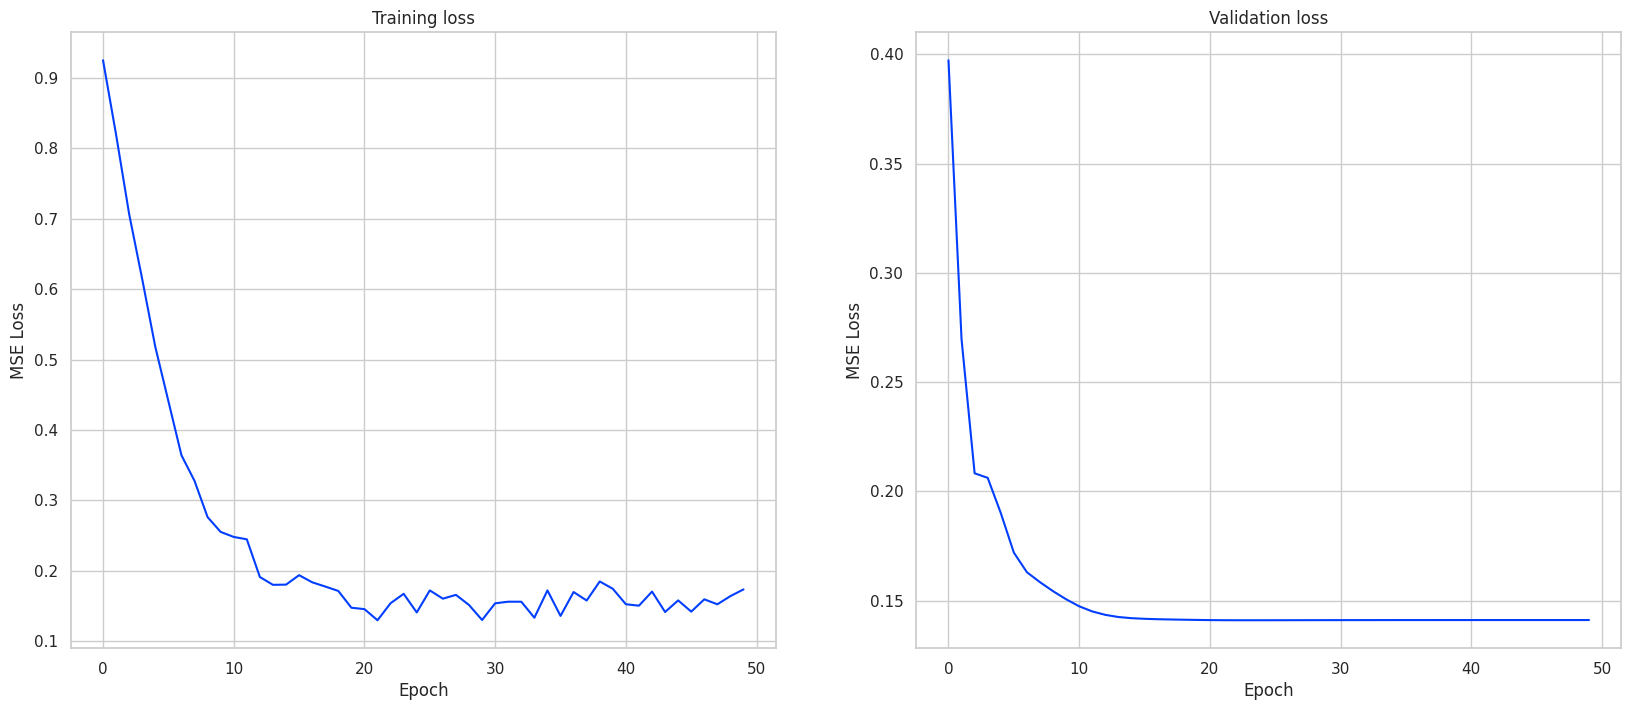

In [410]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [411]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
prediction.shape, true_labels.shape
bert_embeddings_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

MSE     RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  80.43058  8.96831  6.416645  0.156642     0.212488            0.20713   

   Spearman Corr(IC)  
0           0.233539

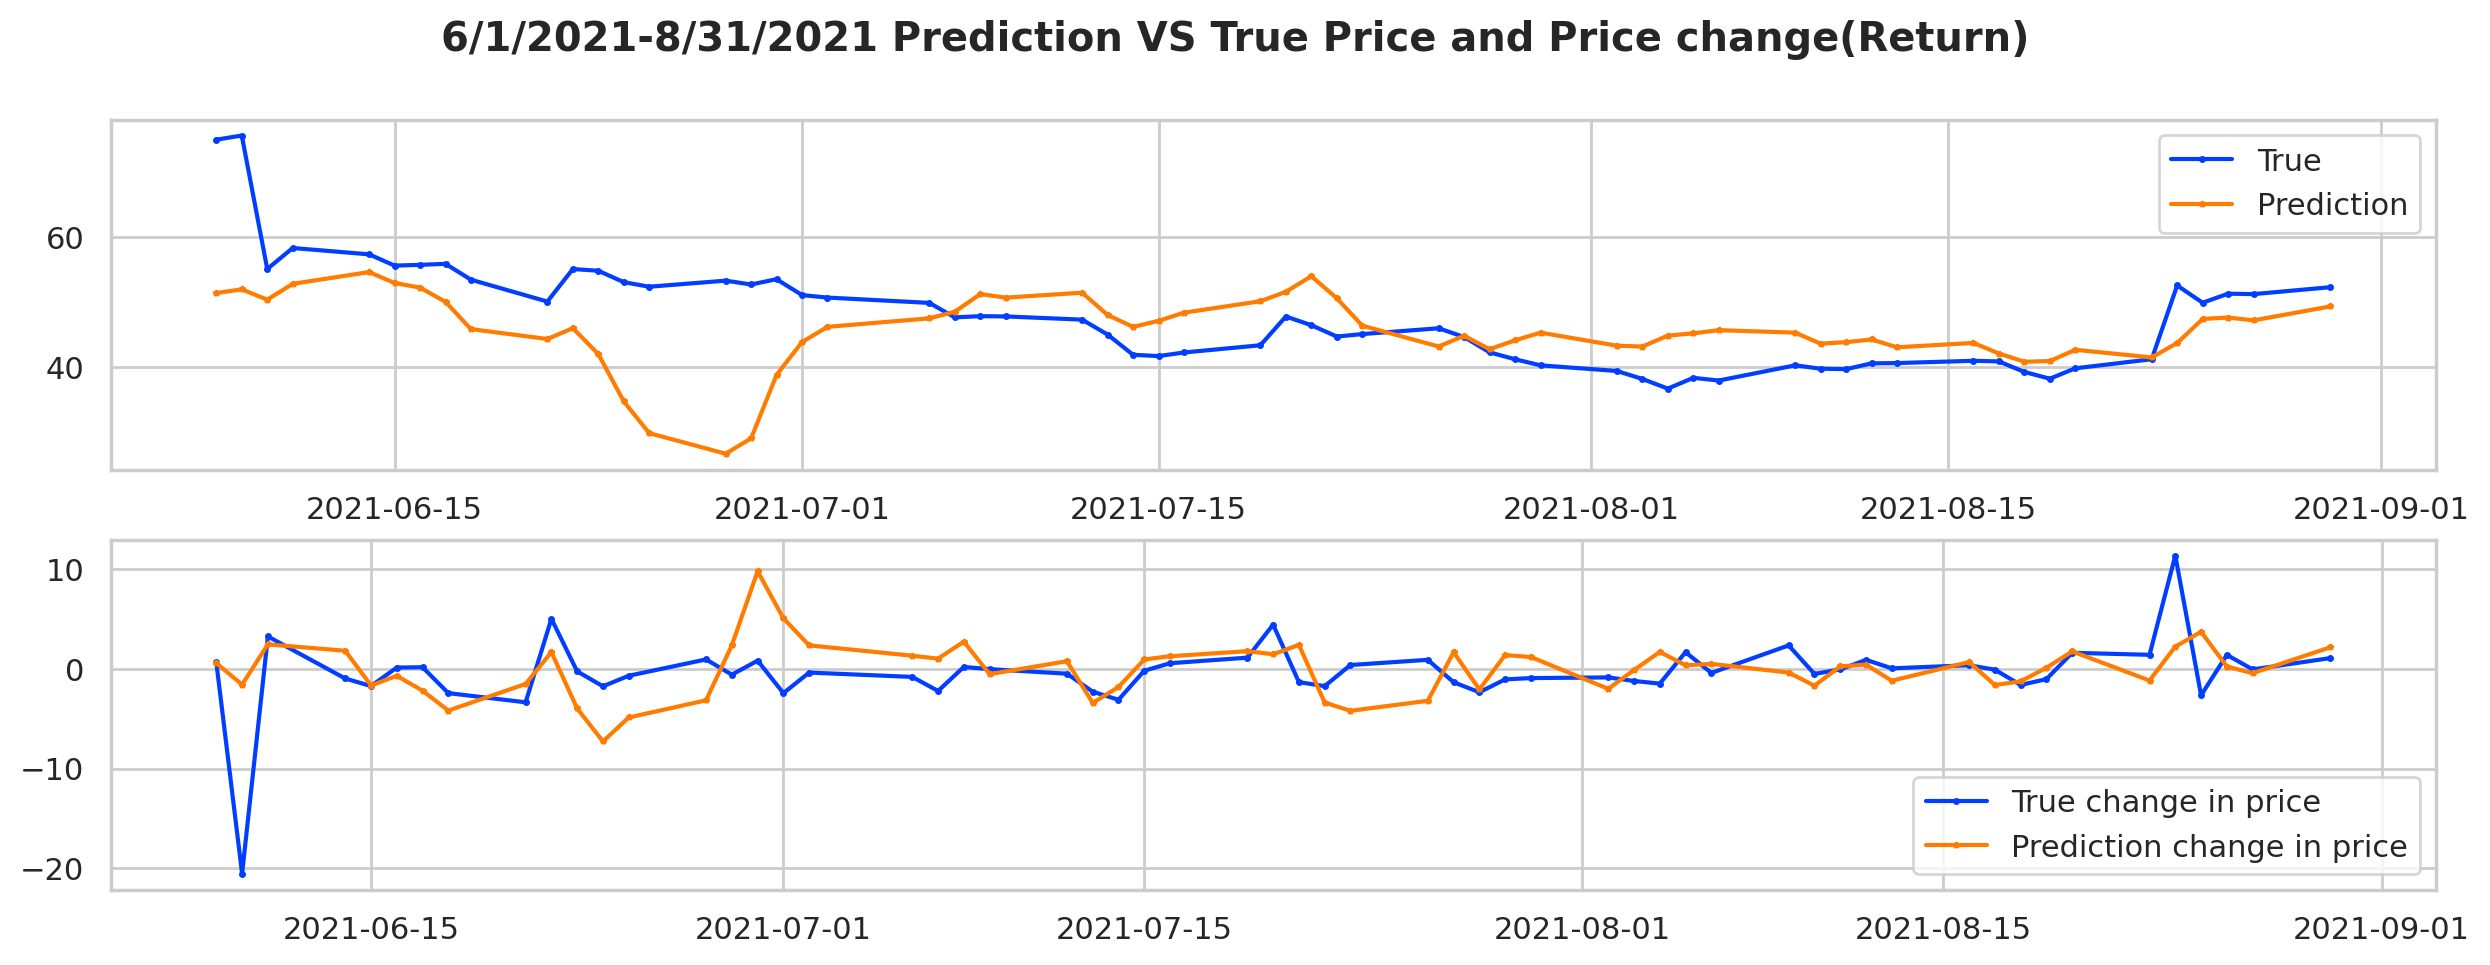

In [412]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [413]:
df_inferencing = df_ts[df_ts.index<pd.to_datetime('2021-09-01')]
inference_indices = get_windows(df_inferencing, window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_inferencing.values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [414]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
# print("Serial Correlation, True Correlation(IC)")
# print(np.corrcoef(prediction,true_labels)[0,1], np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1])
bert_embeddings_train_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  73.347984  8.564344  6.377404  0.539604     0.840778           0.474852   

   Spearman Corr(IC)  
0           0.345038

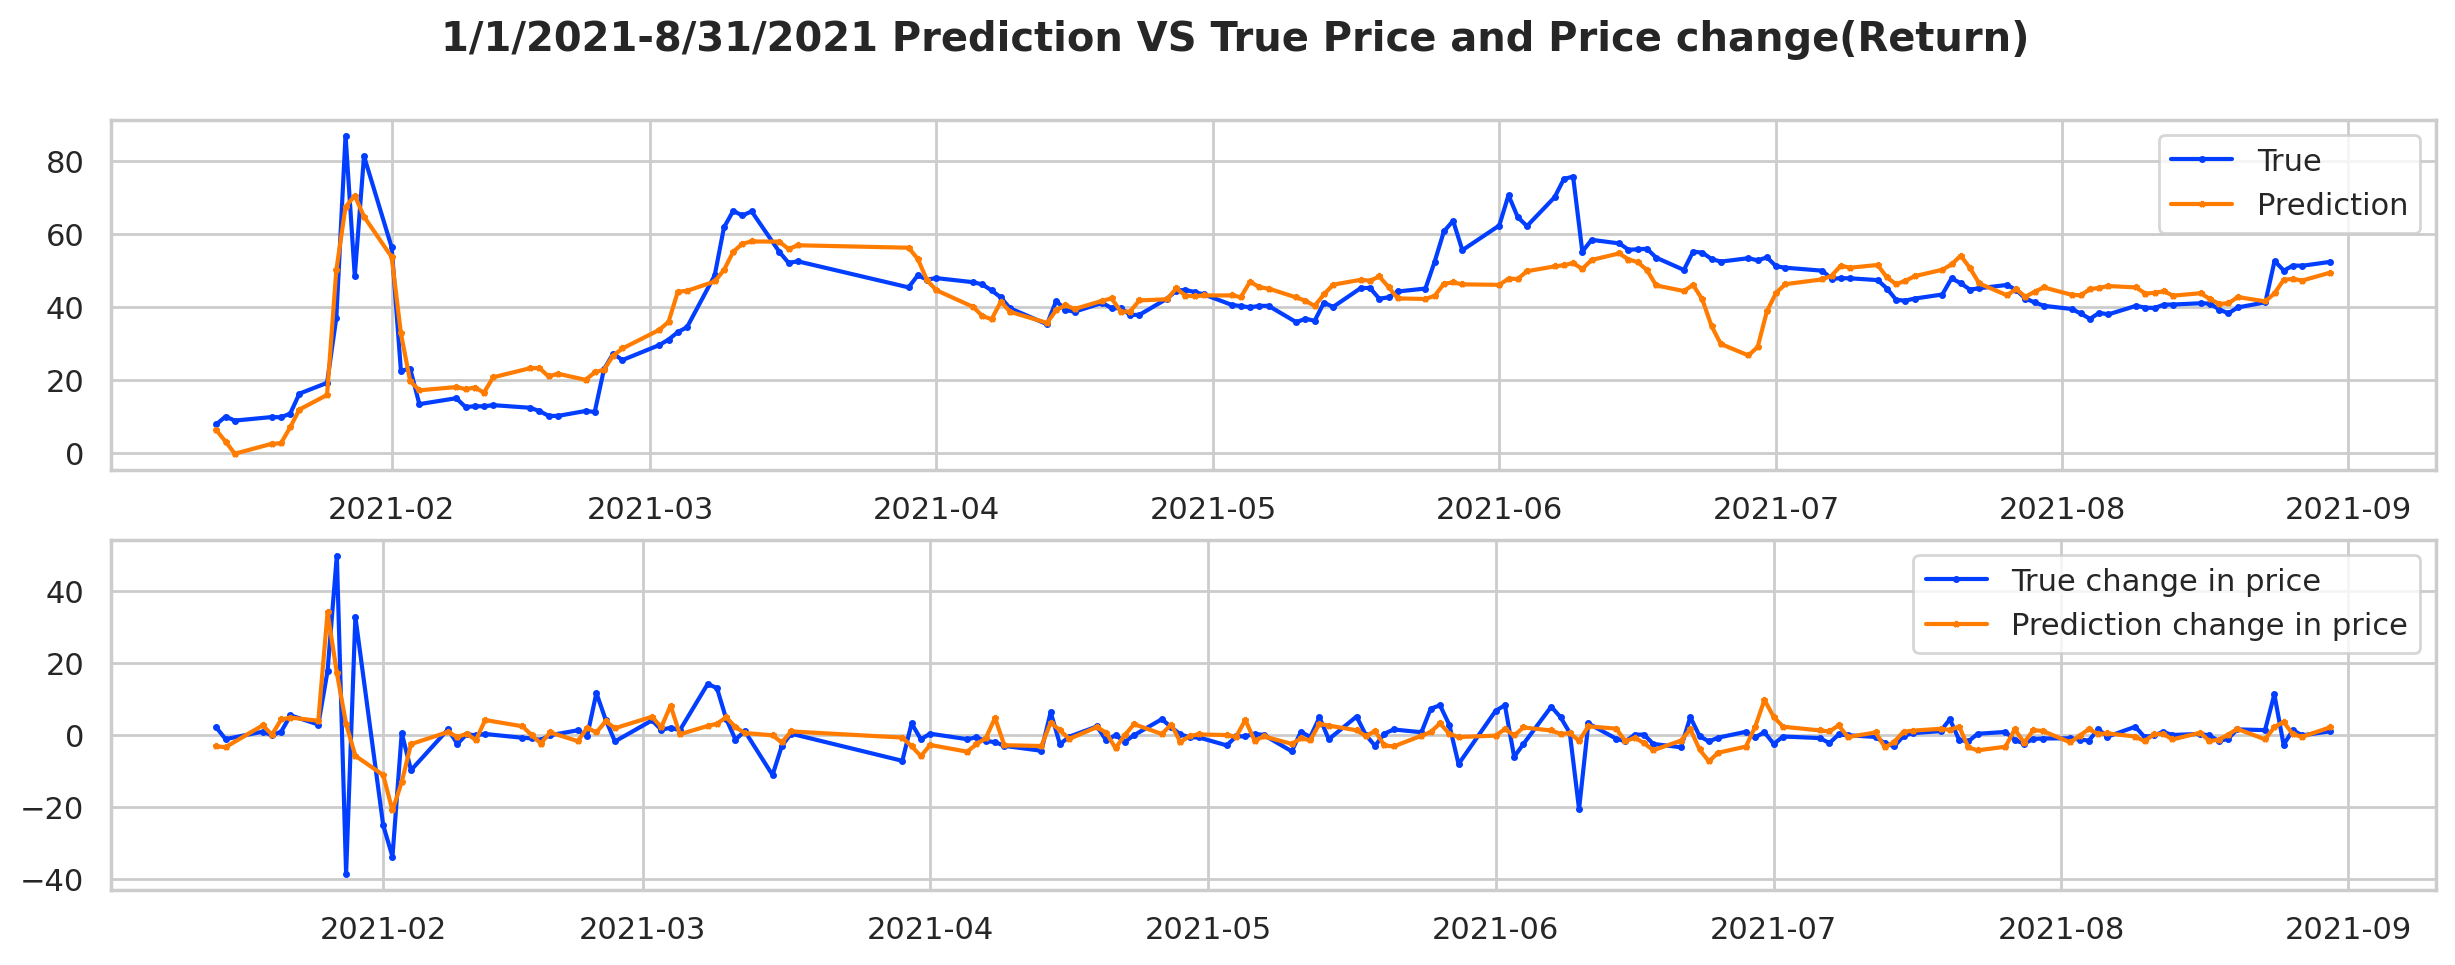

In [415]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:],np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Metrics**

In [416]:
df_metrics = pd.concat([baseline_test_metrics, tfidf_test_metrics, bert_embeddings_test_metrics])
df_metrics.index = ['Baseline_sentiment', 'TF-IDF', 'Bert_embeddings']
df_metrics

MSE       RMSE        MAE      MAPE  Serial Corr  \
Baseline_sentiment   73.073166   8.548284   6.207523  0.143593     0.873002   
TF-IDF              239.582047  15.478438  14.070969  0.417722     0.633061   
Bert_embeddings      80.430580   8.968310   6.416645  0.156642     0.212488   

                    Pearson Corr(IC),  Spearman Corr(IC)  
Baseline_sentiment          -0.177247          -0.097482  
TF-IDF                       0.106105           0.082686  
Bert_embeddings              0.207130           0.233539

# **Sensitivity Test**

In [562]:
df_ts_withfake = df_ts.copy()
#positive injections
df_ts_withfake.loc[pd.to_datetime('2021-08-20'), df_ts_withfake.columns[5:]] = df_ts_withfake.loc[pd.to_datetime('2021-06-07'), df_ts_withfake.columns[5:]]
df_ts_withfake.loc[pd.to_datetime('2021-08-02'), df_ts_withfake.columns[5:]] = df_ts_withfake.loc[pd.to_datetime('2021-06-07'), df_ts_withfake.columns[5:]]

#negative injections
df_ts_withfake.loc[pd.to_datetime('2021-06-02'), df_ts_withfake.columns[5:]] = df_ts_withfake.loc[pd.to_datetime('2021-02-03'), df_ts_withfake.columns[5:]]
df_ts_withfake.loc[pd.to_datetime('2021-06-28'), df_ts_withfake.columns[5:]] = df_ts_withfake.loc[pd.to_datetime('2021-02-03'), df_ts_withfake.columns[5:]]


In [563]:
df_inferencing = df_ts_withfake[df_ts_withfake.index<pd.to_datetime('2021-09-01')]
inference_indices = get_windows(df_inferencing, window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_inferencing.values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [564]:
prediction_fake,true_labels_fake=test(inference_loader)
prediction_fake = prediction_fake.reshape(-1)
true_labels_fake = true_labels_fake.reshape(-1)
print(prediction_fake.shape, true_labels_fake.shape)


Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


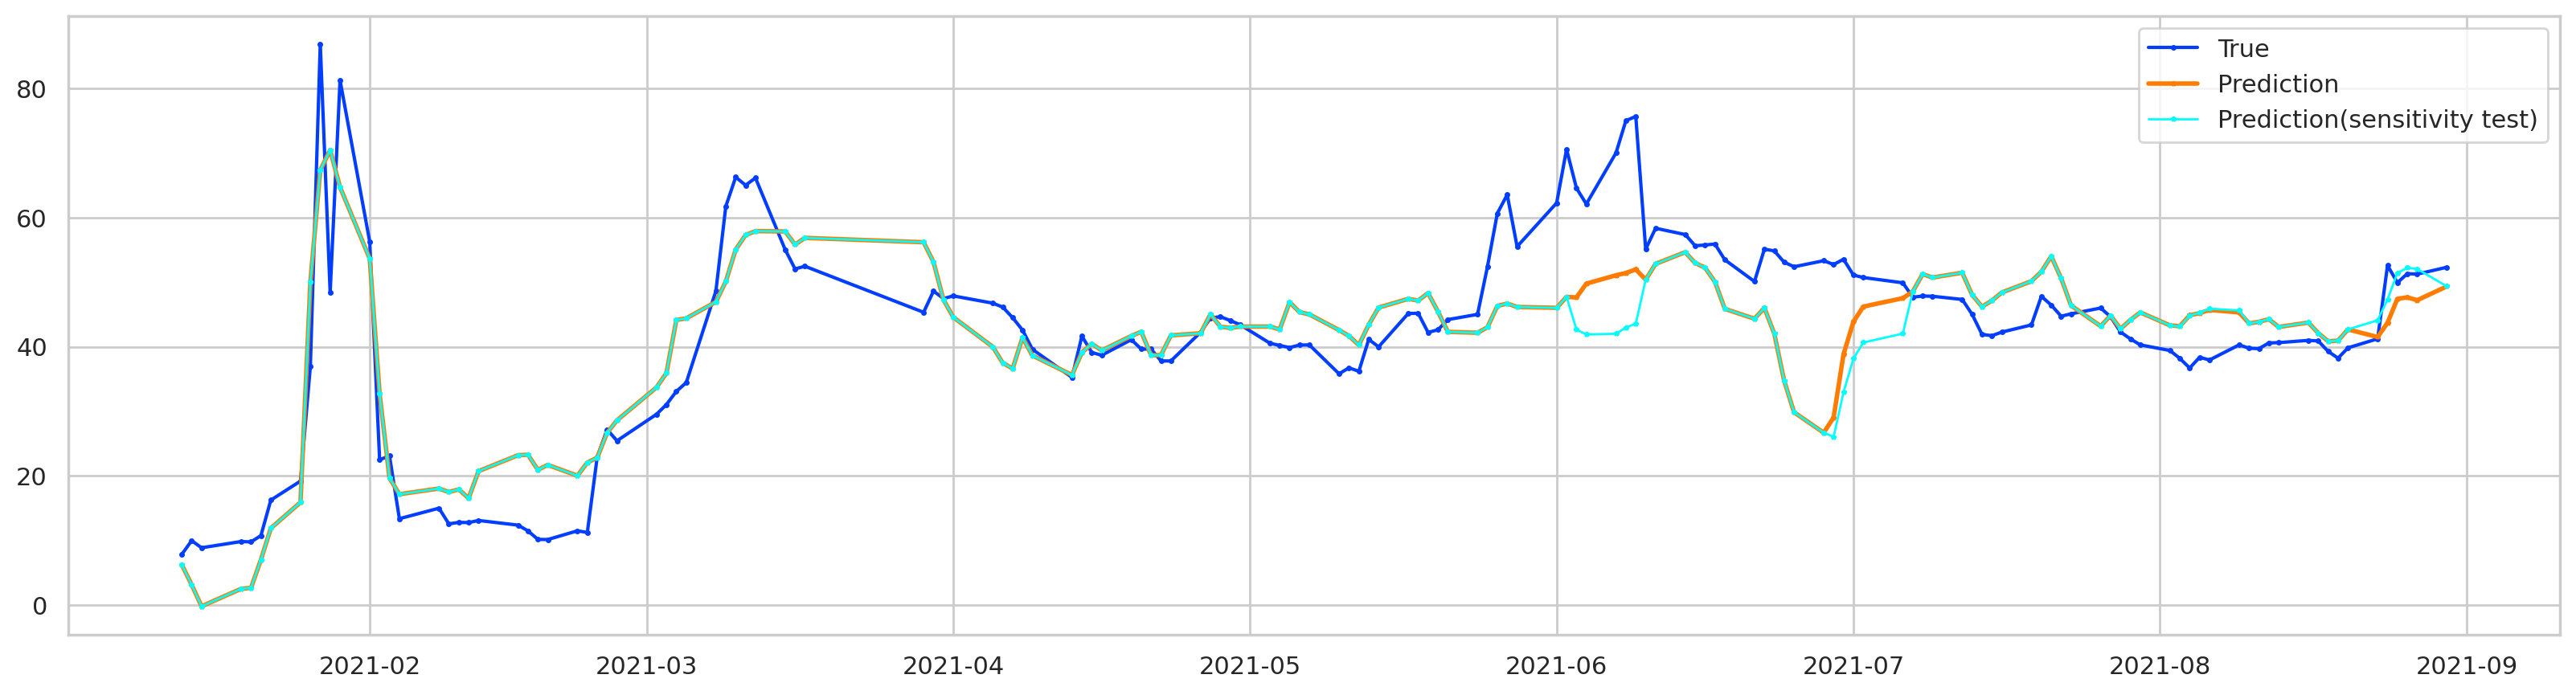

In [565]:
plt.figure(figsize=(20,5),dpi=200)
sns.set_style('whitegrid')
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
plt.plot(date,true_labels, label='True', marker='.', markersize=3)
plt.plot(date,prediction, label='Prediction',marker='*', markersize=2, linewidth=2)
plt.plot(date,prediction_fake, label='Prediction(sensitivity test)',marker='*', markersize=2, color='cyan', linewidth=1)
plt.legend()

plt.show()